<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

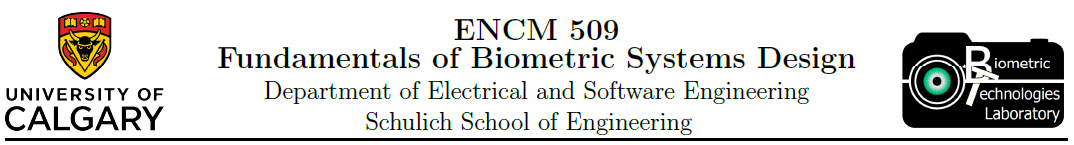

<center>
    <h1>Laboratory Experiment #6</h1>
    <h2>Face Recognition: Feature Extraction and Classification</h2>
</center>

In [1000]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import exposure
import scipy.linalg as la

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from utils_cm import plot_confusion_matrix

import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [1001]:
# You can specify you directory here, please, change the string below:
path = './ATT dataset/s1/'

#### Number of images in your training set.

In [1002]:
# M could be large (for example, 16: 8 of yours and 8 of a friend)
# for At&T dataset there are 10 faces per subject. 
# However, we are going to load only the first 9
# the 10th image will be used to compare later on.
M = 9

#### Image normalization:  

In [1003]:
# can be any number that is close to the std and mean of most of the images.
um = 100
ustd = 80

Reading and showing the images

Size of each image: (112, 92) 10304


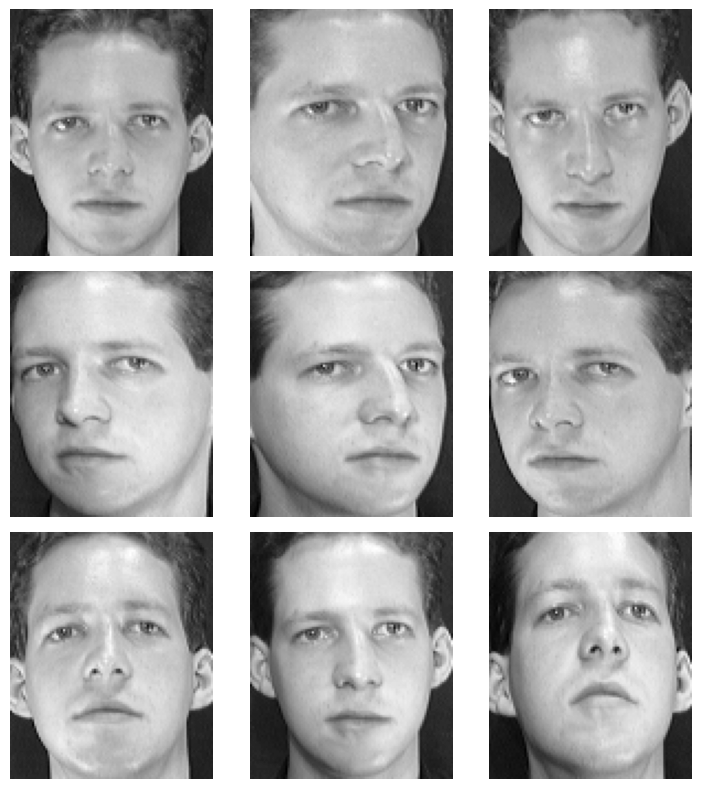

In [1004]:
# loading only one image to get the dimensions
# you can use images .jpg and .ng as well
img = imread(path + '1.pgm', as_gray=True)

# get the number of rows (irow) and columns (icol). 
# these values must to be the same for all images
irow, icol = img.shape

# allocation of vector that will have all images
S = np.zeros((irow*icol, M)) # img matrix

plt.figure(figsize=(8,8))
for i in range(1,M+1):
    img = imread(path + '{}.pgm'.format(i), as_gray=True)
    
    plt.subplot(3,3,i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
    # reshape(img',irow*icol,1); 
    # creates a (N1*N2)x1 vector
    temp = np.reshape(img, (irow*icol,1))
    S[:,i-1] = temp[:,0] 
# after finishing the sequence, S is a N1*N2xM matrix 

print('Size of each image:', img.shape, np.multiply(img.shape[0], img.shape[1]))

Here we **normalize** all images by changing the *mean* and *std* of each one. This is done to reduce the error due to lighting conditions and background.

In [1005]:
# looping over all the loaded images in S to normalize
for i in range(S.shape[1]):
    temp = S[:,i]
    m = np.mean(temp)
    st = np.std(temp)
    # calculation where are defined the new pixels intensities
    S[:,i] = (temp - m) * ustd / st + um

### Normalized images

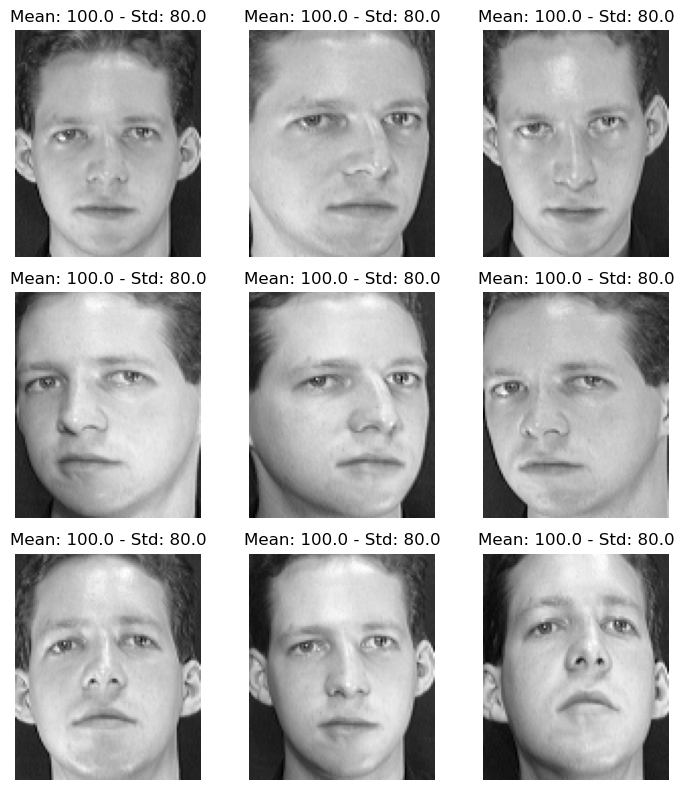

In [1006]:
plt.figure(figsize=(8,8))
for i in range(M):
    img = np.reshape(S[:,i], (irow, icol))
    
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Mean: %.1f - Std: %.1f' % (np.mean(img), np.std(img)))

#### Mean image

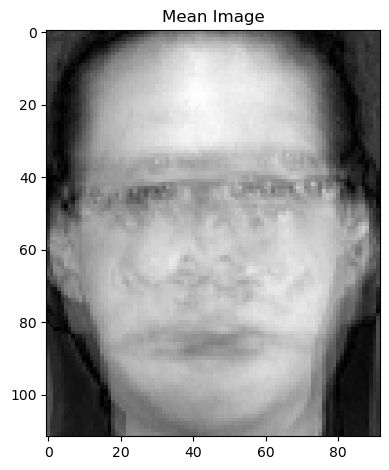

In [1007]:
# calculates the mean of each row instead of each column
m = np.mean(S, axis=1)
# converts to unsigned 8-bit integer. Values range from 0 to 255
m = np.uint8(np.abs(m)).reshape(-1,1) 

img = np.reshape(m, (irow, icol))
plt.imshow(img, cmap='gray')
plt.title('Mean Image');

#### Creating covariance matrix  L

In [1008]:
dbx = S.copy()
A = dbx.T
L = np.matmul(A, A.T)

# vv is the eigenvector for L
# dd is the eigenvalue for  L = dbx.T*dbx
dd, vv = la.eig(L)

#### Sort and eliminate zero eigenvalue

In [1009]:
v = np.zeros(vv.shape)
d = np.zeros(dd.shape)

for i in range(vv.shape[1]):
    if (dd[i] > 1e-4):
        v[:,i] = vv[:,i]
        d[i] = dd[i]
        
# sort d in ascending order
index = np.argsort(d)
B = d[index]
ind = np.zeros(index.shape).astype(int)
dtemp = np.zeros(index.shape)
vtemp = np.zeros(v.shape)

idx_len = len(index)
for i in range(idx_len):
    dtemp[i] = B[idx_len-1-i]
    ind[i] = idx_len-1-index[i]
    vtemp[:,ind[i]] = v[:,i]

d = dtemp
v = vtemp

/var/folders/vl/ch29fks90xn1m477v18qgtvm0000gn/T/ipykernel_24864/184907035.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i] = dd[i]


#### Normalization of eigenvectors

In [1010]:
for i in range(v.shape[1]):
    kk = v[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    v[:,i] = v[:,i] / temp
    
# Eigenvectors of C matrix
u = np.zeros(dbx.shape)
for i in range(v.shape[1]):
    temp = np.sqrt(d[i])
    u[:,i] = np.matmul(dbx, v[:,i]) / temp
    
for i in range(u.shape[1]):
    kk = u[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    u[:,i] = u[:,i] / temp

#### Showing eigenfaces

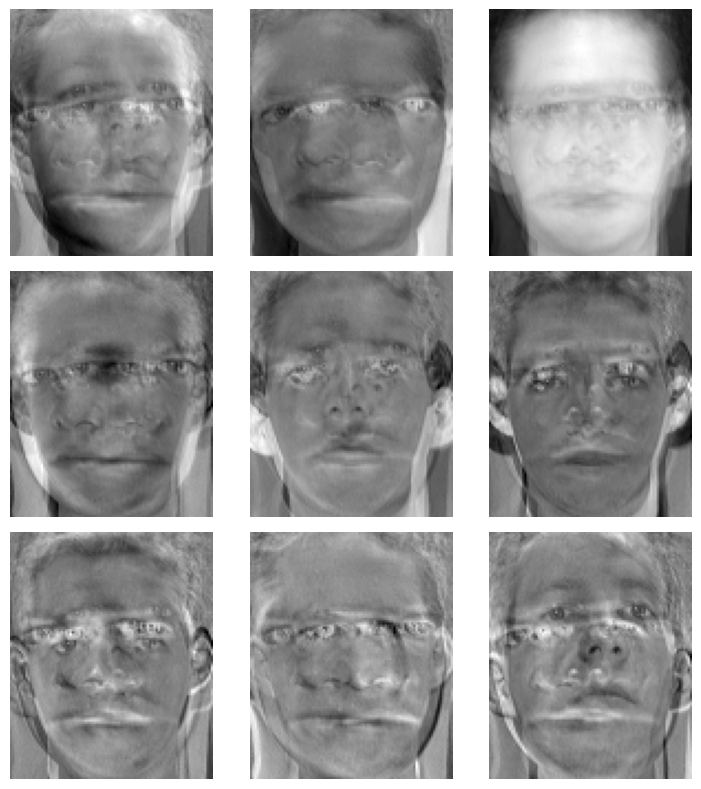

In [1011]:
plt.figure(figsize=(8,8))
for i in range(M):
    img = np.reshape(u[:,i], (irow, icol))
    
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

#### Find the weight of each face in the training set

In [1012]:
omega = np.zeros((M,M))
WW = np.zeros((M,1))

for h in range(dbx.shape[1]):
    for i in range(u.shape[1]):
        t = u[:,i].T
        WeightOfImage = np.dot(t, dbx[:,h].T)
        WW[i] = WeightOfImage
    omega[:,h] = WW[:,0]

## Acquisition of new image: Same subject
*Notes*: 
- The input image must have a bmp, jpg or pgm extension. 
- It should have the same size as the ones in your training set. 

In [1013]:
# using the last image of subject #1
path = './ATT dataset/s1/'
InputImage = imread(path + '10.pgm', as_gray=True)

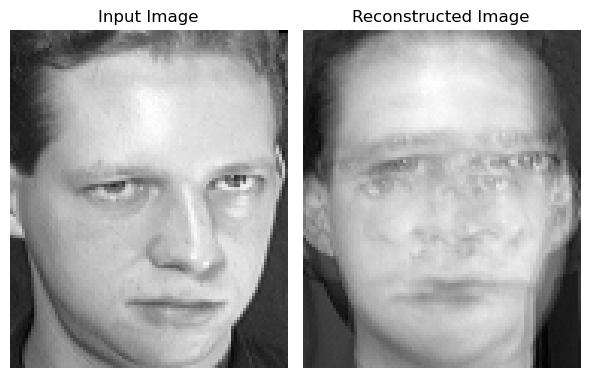

In [1014]:
plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference: NormalizedImage - MeanImage
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage

#### Finding the Euclidean distance

In [1015]:
eSameSubject = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eSameSubject[i] = mag

# max/min Euclidean distance
MaximumValue = np.max(eSameSubject) 
MinimumValue = np.min(eSameSubject) 

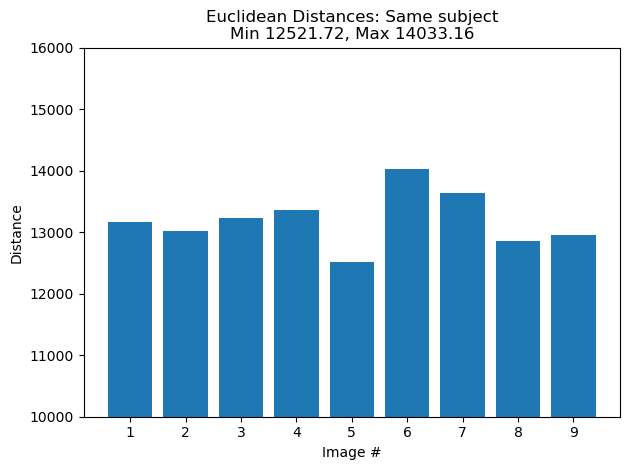

In [1016]:
labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9')

plt.bar(np.arange(len(eSameSubject)), eSameSubject.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Same subject\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));

## Acquisition of new image: Other subject
*Notes*: 
- The input image must have a bmp, jpg or pgm extension. 
- It should have the same size as the ones in your training set. 

In [1017]:
# using the first face ('1.pgm') from subject 20
path = './ATT dataset/s20/'
InputImage = imread(path + '1.pgm', as_gray=True)

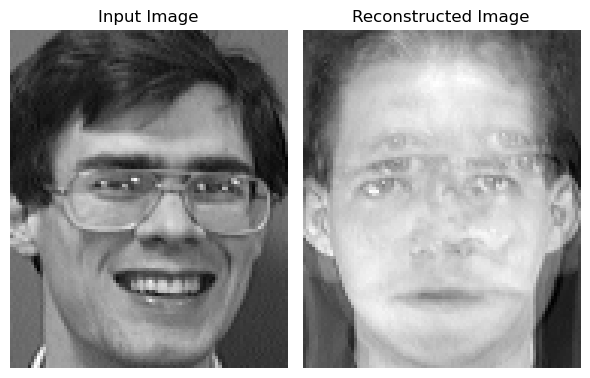

In [1018]:
plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage

### Finding the Euclidean distance

In [1019]:
eDiffSubject = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eDiffSubject[i] = mag
    
# max/min Eucledian distance
MaximumValue = np.max(eDiffSubject) 
MinimumValue = np.min(eDiffSubject) 

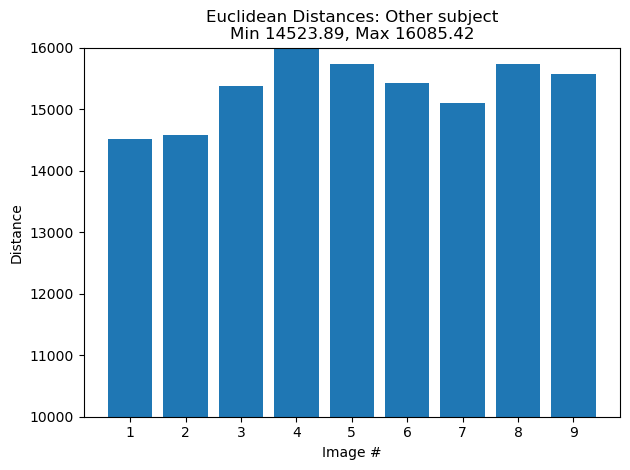

In [1020]:
labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9')

plt.bar(np.arange(len(eDiffSubject)), eDiffSubject.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Other subject\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));

## Acquisition of new image: Not Human Face
*Notes*: 
- The input image must have a bmp, jpg or pgm extension. 
- It should have the same size as the ones in your training set. 

In [1021]:
# using the first face ('1.pgm') from subject 20
path = './'
InputImage = imread(path + 'CalgaryTower.jpg', as_gray=True)

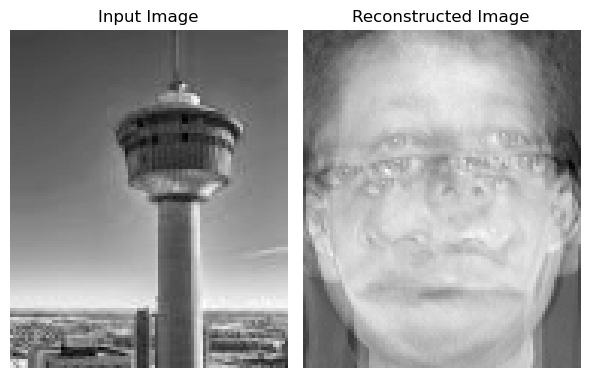

In [1022]:
plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage

### Finding the Euclidean distance

In [1023]:
eTower = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eTower[i] = mag
    
# max/min Eucledian distance
MaximumValue = np.max(eTower) 
MinimumValue = np.min(eTower) 

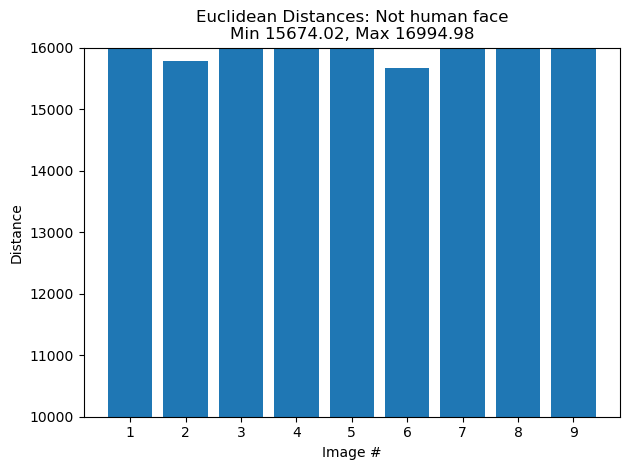

In [1024]:
labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9')

plt.bar(np.arange(len(eTower)), eTower.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Not human face\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));

#### Change and uncomment the fragment below using your Threshold values to classify the face as "Match", "non-Match", or "Not-a-face"

In [1025]:
# Set Threshold Values 
threshold1 = 14000
threshold2 = 15500

distances = eSameSubject
#distances = eDiffSubject
#distances = eTower


mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Image is in the database')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database')
elif (mean_of_distances > threshold2):
    print('Image is not a face')

Image is in the database


## Using PCA and KNN with Scikit-Learn

In [1026]:
def prediction_evaluation(predicted_label, true_label, subject_id=1):
    # accuracy can be calculated as: 
    # predictedRight / (predictedRight + predictedWrong)
    right, wrong = 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == realLabel:
            right += 1
        else:
            wrong += 1
    acc = right / (right + wrong) 
    print("Overall Accuracy: %d%%" % (acc * 100))
    
    # True Positive (TP): real label IS subject_id and predicted label IS subject_id
    # False Positive (FP): real label is NOT subject_id while predicted label IS subject_id
    # True Negative (TN): real label is NOT subject_id and predicted label is NOT subject_id
    # False Negative (FN): real label IS subject_id and predicted label is NOT subject_id
    
    TP, FP, TN, FN = 0, 0, 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == subject_id and realLabel == subject_id:
            TP += 1
        if predictedLabel != subject_id and realLabel == subject_id:
            FN += 1
        if predictedLabel != subject_id and realLabel != subject_id:
            TN += 1
        if predictedLabel == subject_id and realLabel != subject_id:
            FP += 1
    print("Subject #%d:\n\tTP: %d, FP: %d, TN: %d, FN: %d" % (subject_id, TP, FP, TN, FN))
    
    # True Positive Rate (TPR) also known as Sensitivity or Recall
    TPR = TP / (TP + FN)
    # True Negative Rate (TNR) also known as Specificity
    TNR = TN / (TN + FP)
    # False Positive Rate (FPR)
    FPR = FP / (FP + TN)
    # False Negative Rate (FNR)
    FNR = FN / (TP + FN)

    print("\tTPR: %.2f%%, TNR: %.2f%%, FPR: %.2f%%, FNR: %.2f%%" % (TPR*100, TNR*100, FPR*100, FNR*100))

    return { "Overall Accuracy" : (acc * 100), "subject_id" : subject_id, 
            "TP" : TP, "FP" : FP, "TN" : TN, "FN" : FN, "TPR" : TPR*100, 
            "TNR" : TNR*100, "FPR" : FPR*100, "FNR" : FNR*100}

In [1027]:
n_subjects = 20

# number of images should sum to 10
n_training_images = 5
n_test_images = 5

knn_neighbors = 3

# You can specify you directory here, please, change the string below:
path = '../ATT dataset/'

print('For EACH of all the %d subjects:' % (n_subjects))
print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])

For EACH of all the 20 subjects:
	5 images will be used for TRAINING: [1, 2, 3, 4, 5]
	5 images will be used for TEST: [6, 7, 8, 9, 10]


### Descriptor: Principal Component Analysis (PCA)

In [1028]:
# use the first 5 images from subjectID 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        trainingFaces.append(np.reshape(img, (img.size,)))
        trainingLabels.append(subjectId)

# use the last 5 images from subjectID 1-20 to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        testingFaces.append(np.reshape(img, (img.size,)))
        testingLabels.append(subjectId)

In [1029]:
print('Training faces:', len(trainingFaces))
print('Size of each sample:', len(trainingFaces[0]))

Training faces: 100
Size of each sample: 10304


### Initializing the PCA

In [1030]:
# n_components: number of principal components
n_components_pca = 100
pca = PCA(n_components=n_components_pca)

# fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
pca.fit(trainingFaces);

#### Apply PCA to the two sets: Training and Test

In [1031]:
train_pca = pca.transform(trainingFaces)
test_pca = pca.transform(testingFaces)

#### Mean image

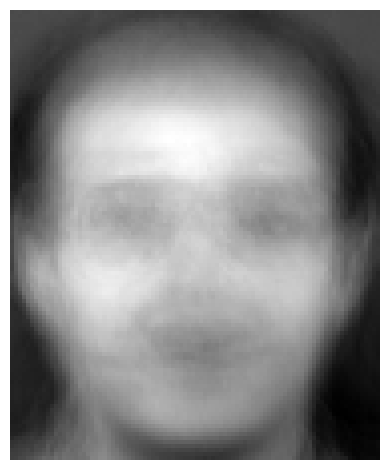

In [1032]:
plt.imshow(pca.mean_.reshape(img.shape))
plt.axis('off');

#### Eigenfaces

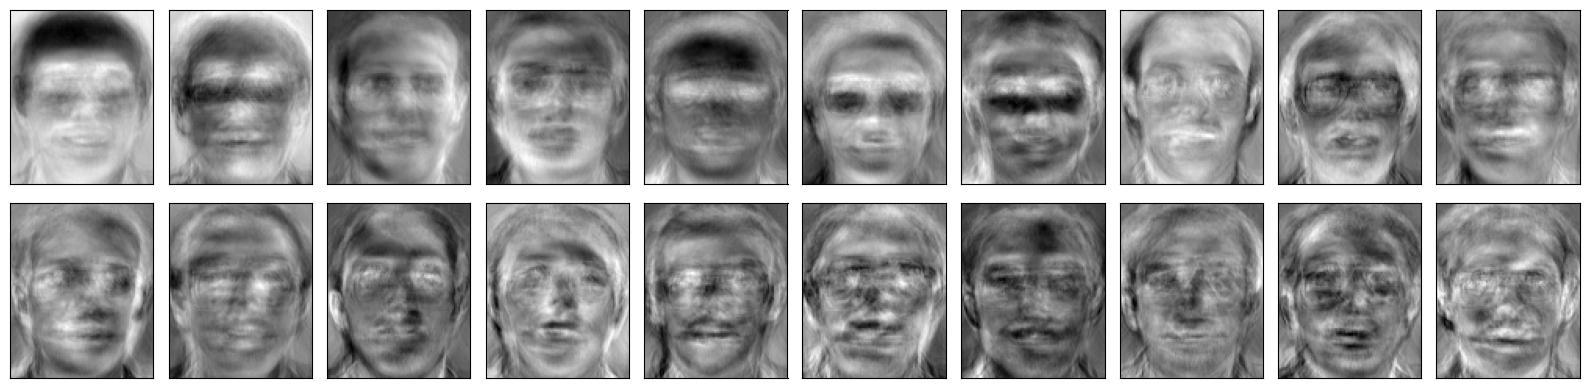

In [1033]:
fig = plt.figure(figsize=(16, 6))
for i in range(20):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(img.shape))

### Training the KNN

In [1034]:
knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)

In [1035]:
predictedLabels = knn_pca.predict(test_pca)

### Evaluating the Results

In [1036]:
prediction_evaluation(predictedLabels, testingLabels)

Overall Accuracy: 91%
Subject #1:
	TP: 4, FP: 0, TN: 95, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


{'Overall Accuracy': 91.0,
 'subject_id': 1,
 'TP': 4,
 'FP': 0,
 'TN': 95,
 'FN': 1,
 'TPR': 80.0,
 'TNR': 100.0,
 'FPR': 0.0,
 'FNR': 20.0}

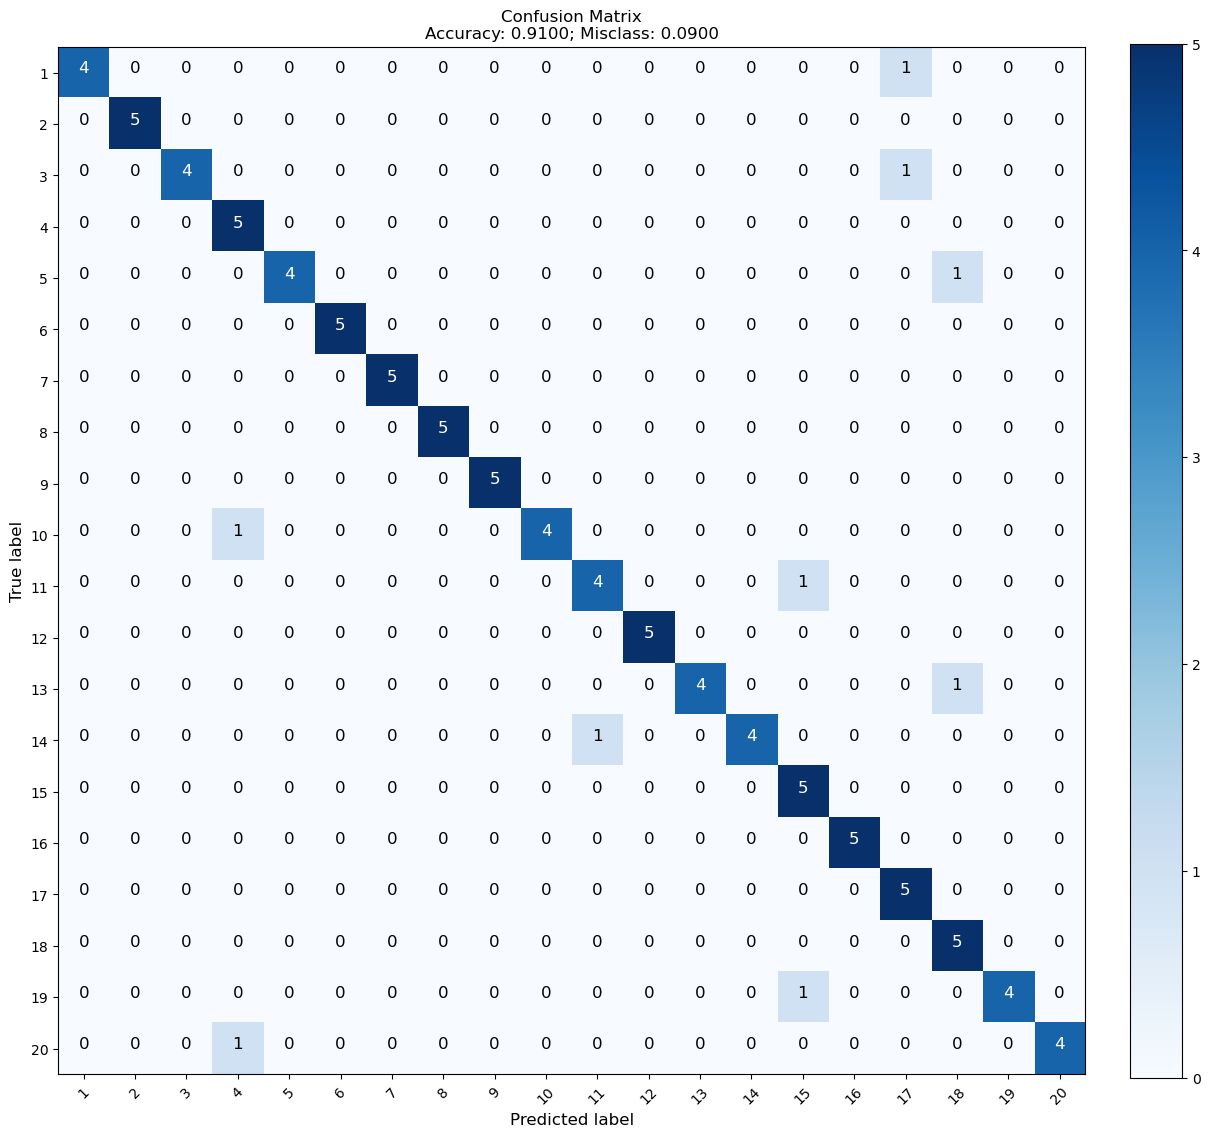

In [1037]:
# Generate the confusion matrix
confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

plot_confusion_matrix(cm=confusionMatrix,
                      target_names = [i for i in range(1, n_subjects+1)])

### Evaluating how many Principal Components are necessary

In [1038]:
lst_components = range(pca.n_components_)

pca_explained_var = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues
cum_sum_eigenvalues = np.cumsum(pca_explained_var)

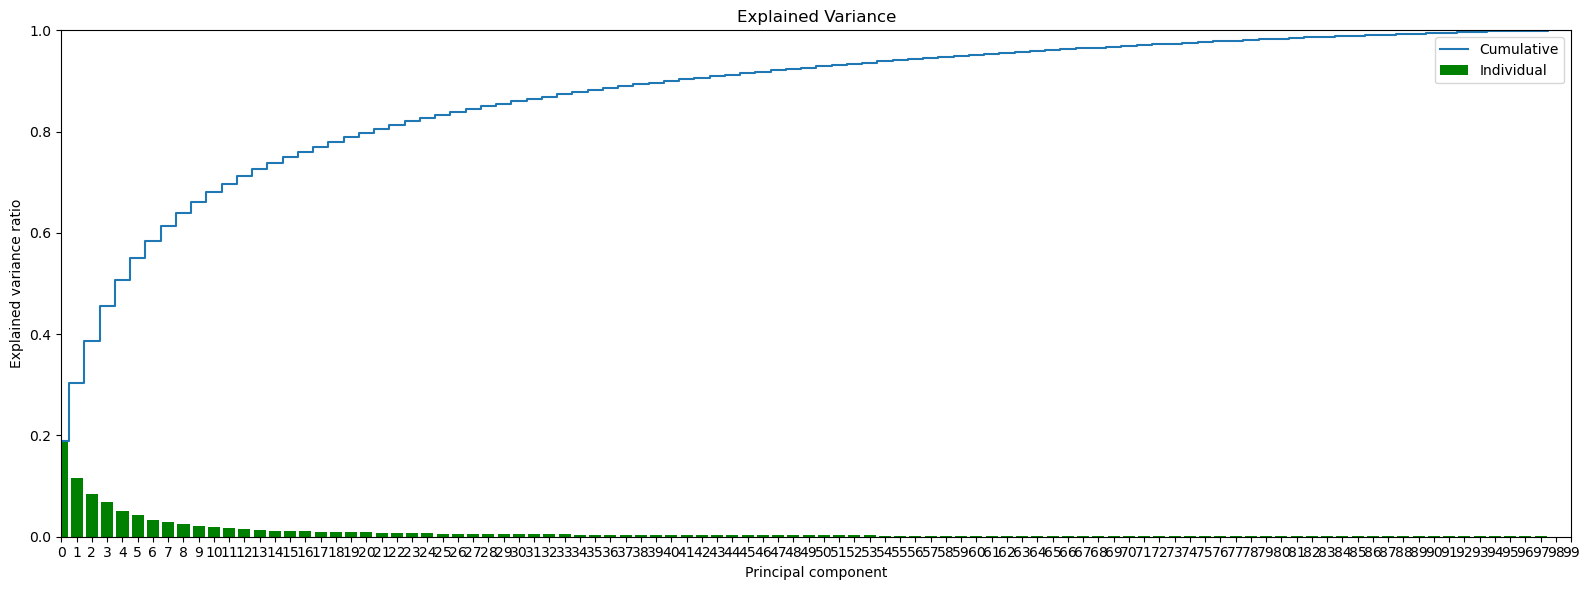

In [1039]:
plt.figure(figsize=(16,6))
plt.bar(lst_components, pca_explained_var, label='Individual', color='green')
plt.step(lst_components, cum_sum_eigenvalues, where='mid', label='Cumulative')
plt.title('Explained Variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component')
plt.legend()
plt.xlim([0, n_components_pca-1])
plt.ylim([0,1])
plt.xticks(lst_components)
plt.show()

## Exercises

**General Marks**
1. Introduction (a paragraph about the purpose of the lab).
1. Description of the result on each exercise  with illustrations/graphs and analysis of the results (marks are distributed as shown in the Exercise section). (10 marks)
1. Conclusion (a paragraph on what is the main take-out of the lab).

- **Exercise 1** (3 marks): For this exercise, you are going to build a gallery and perform the classification (matching) for the three cases (face known to the gallery, face unknown to the gallery and not-a-face). You need to choose two or three different subjects (for example, subjects 2, 3 and 4) from the dataset, or create your own dataset. Use the first 9 images of each subject to build the gallery dataset. For example, if you choose 3 subjects, then you have a gallery of 3 x 9 = 27 faces, and for algorithm each image is a sample, or input (no separate model is built per subject).

    Now, choose the probe images as follows:
    1. The 10th image of each of the three subjects in the dataset.
    2. 2-3 faces of the subjects not known to the dataset (could be yours, if you wish).
    3. 1-2 not-a-face image.

    For each of the comparisons, save the Euclidean distances calculated and annotate the minimum and maximum value in each case.

- **Exercise 2** (3 marks):Determine the first and the second thresholds; hint: analyze the maximum of the Euclidean distances for the probe images known to the dataset. To find the second threshold, use unknown faces as the input faces and gather all the Euclidean distance. Hint: consider the maximum as the second threshold, but also analyze other values.

    Extend the Lab’s Jupyter notebook, so that it can calculate the thresholds as investigated above in Exercise 2, and provide the decision output: ‘Face is known to the dataset, subject 2’, ‘Face is unknown to the dataset’, or ‘Not-a-face’. Draw conclusions and make suggestions on the procedure improvement.

- **Exercise 3** (2 marks): In the description of the face recognition using PCA and KNN above, the PCA was used with 100 principal components. Now repeat the same procedure using 50 and 200 principal components. Evaluate the resulting classifier accuracy, using Confusion matrix. Visualize the comparison using either a table or a bar plot (comparing the results for the three number of components: 50, 100 (already done) and 200).


In [1040]:
def faceSetMaker(n_subjects, train, test):
    n_training_images = train
    n_test_images = test

    print('For EACH of all the %d subjects:' % (n_subjects))
    print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
    print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])

    # use the first 5 images from subjectID 1-n_subjects to train the classifier
    trainingFaces = []
    trainingLabels = []
    for subjectId in range(1, n_subjects+1):
        for imageId in range(1, n_training_images+1):
            img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
            trainingFaces.append(np.reshape(img, (img.size,)))
            trainingLabels.append(subjectId)

    # use the last 5 images from subjectID 1-20 to test the classifier
    testingFaces = []
    testingLabels = []
    for subjectId in range(1, n_subjects+1):
        for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
            img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
            testingFaces.append(np.reshape(img, (img.size,)))
            testingLabels.append(subjectId)
    return {"n_subjects" : n_subjects, "trainingFaces" : trainingFaces, "trainingLabels" : trainingLabels, 
            "testingFaces" : testingFaces, "testingLabels" : testingLabels}

In [1041]:
def use_PCA_and_KNN(component_num=100, samples=20, train=5,test=5, neighbors=3):
    # n_components: number of principal components
    pca = PCA(n_components=component_num)
    subjects=faceSetMaker(samples, train, test)

    # fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
    pca.fit(subjects['trainingFaces']);

    print("\n\n\n--------------------------")
    print("Applying PCA to the two sets: Training and Test...")
    train_pca = pca.transform(subjects['trainingFaces'])
    test_pca = pca.transform(subjects['testingFaces'])
    
    print("Training the KNN...")
    knn_pca = KNeighborsClassifier(n_neighbors=neighbors).fit(train_pca, subjects['trainingLabels'])
    predictedLabels = knn_pca.predict(test_pca)
    print("--------------------------")


    

    # Generate the confusion matrix
    confusionMatrix = confusion_matrix(subjects['testingLabels'], predictedLabels)
    plot_confusion_matrix(cm=confusionMatrix,
                        target_names = [i for i in range(1, subjects['n_subjects']+1)])
    
    return prediction_evaluation(predictedLabels, subjects['testingLabels'])


### NOTE: 
All of the cases will use all 40 subjects as we need to have atleast 200 features to have 200 principal components. We will also change the train and test split to be 8 and 2 as advised in the lab handout.

#### Reference Data (Principal components = 100)

For EACH of all the 40 subjects:
	8 images will be used for TRAINING: [1, 2, 3, 4, 5, 6, 7, 8]
	2 images will be used for TEST: [9, 10]



--------------------------
Applying PCA to the two sets: Training and Test...
Training the KNN...
--------------------------


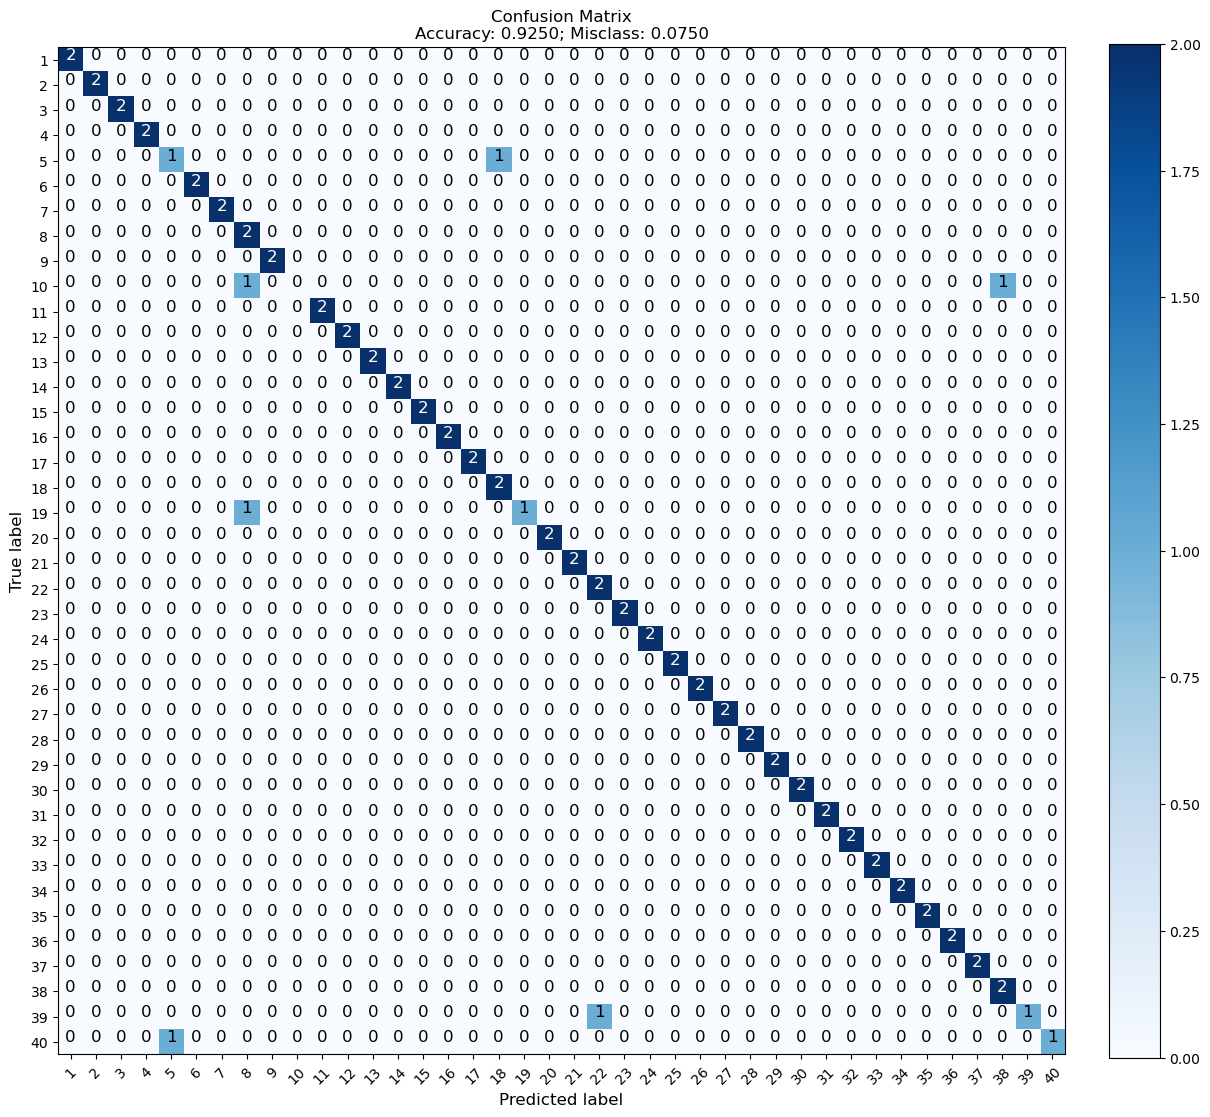

Overall Accuracy: 92%
Subject #1:
	TP: 2, FP: 0, TN: 78, FN: 0
	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%


In [1042]:
components_100=use_PCA_and_KNN(100, 40, 8, 2)

#### modified Data (Principal components = 200)

For EACH of all the 40 subjects:
	8 images will be used for TRAINING: [1, 2, 3, 4, 5, 6, 7, 8]
	2 images will be used for TEST: [9, 10]



--------------------------
Applying PCA to the two sets: Training and Test...
Training the KNN...
--------------------------


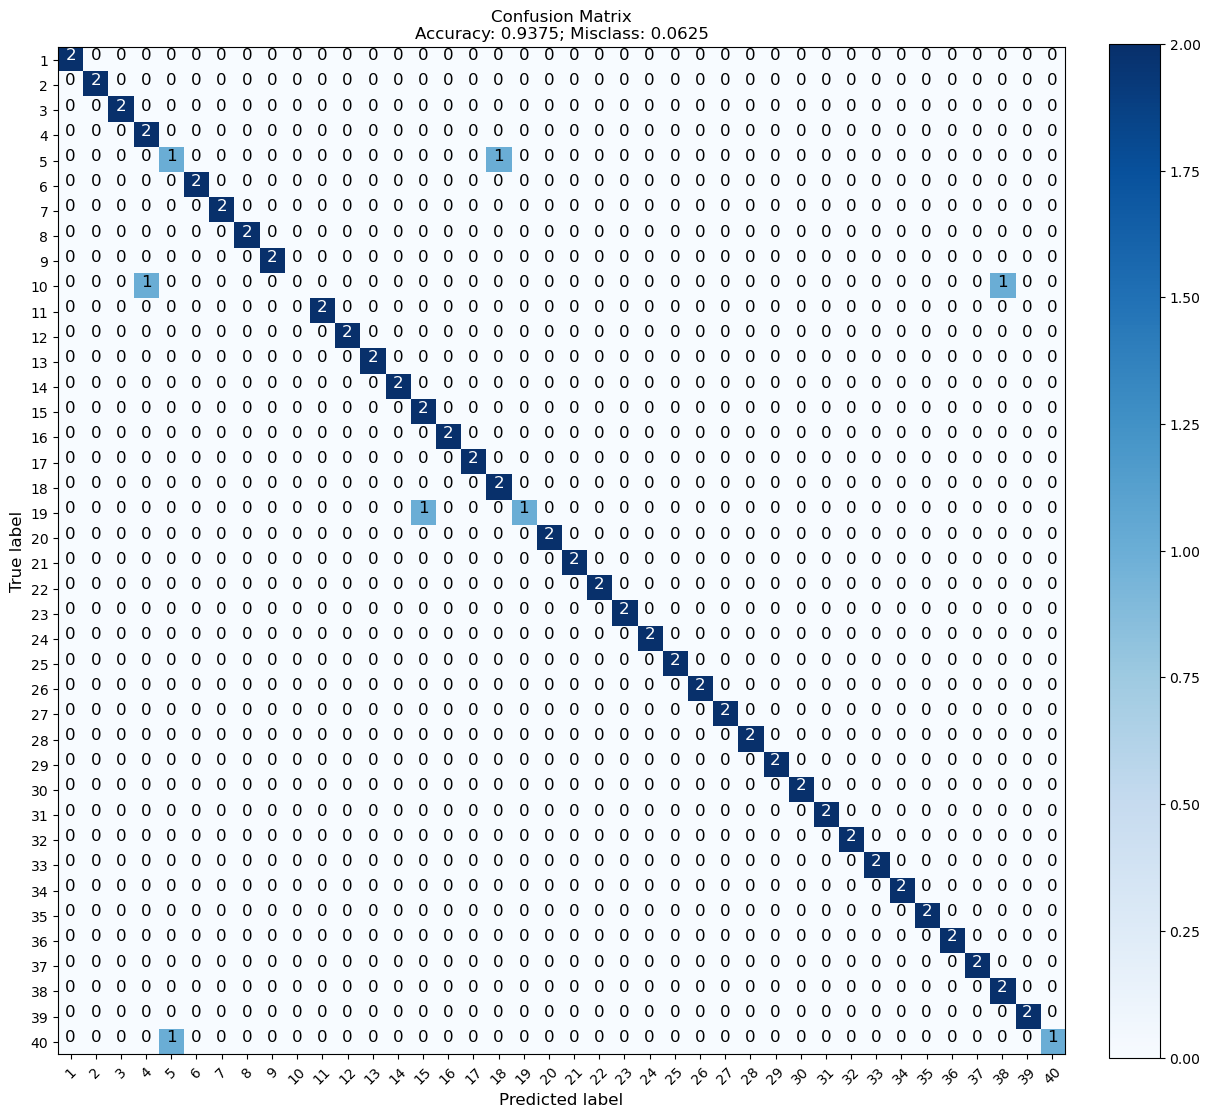

Overall Accuracy: 93%
Subject #1:
	TP: 2, FP: 0, TN: 78, FN: 0
	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%


In [1043]:
components_200=use_PCA_and_KNN(200,40, 8, 2)

#### modified Data (Principal components = 50)

For EACH of all the 40 subjects:
	8 images will be used for TRAINING: [1, 2, 3, 4, 5, 6, 7, 8]
	2 images will be used for TEST: [9, 10]



--------------------------
Applying PCA to the two sets: Training and Test...
Training the KNN...
--------------------------


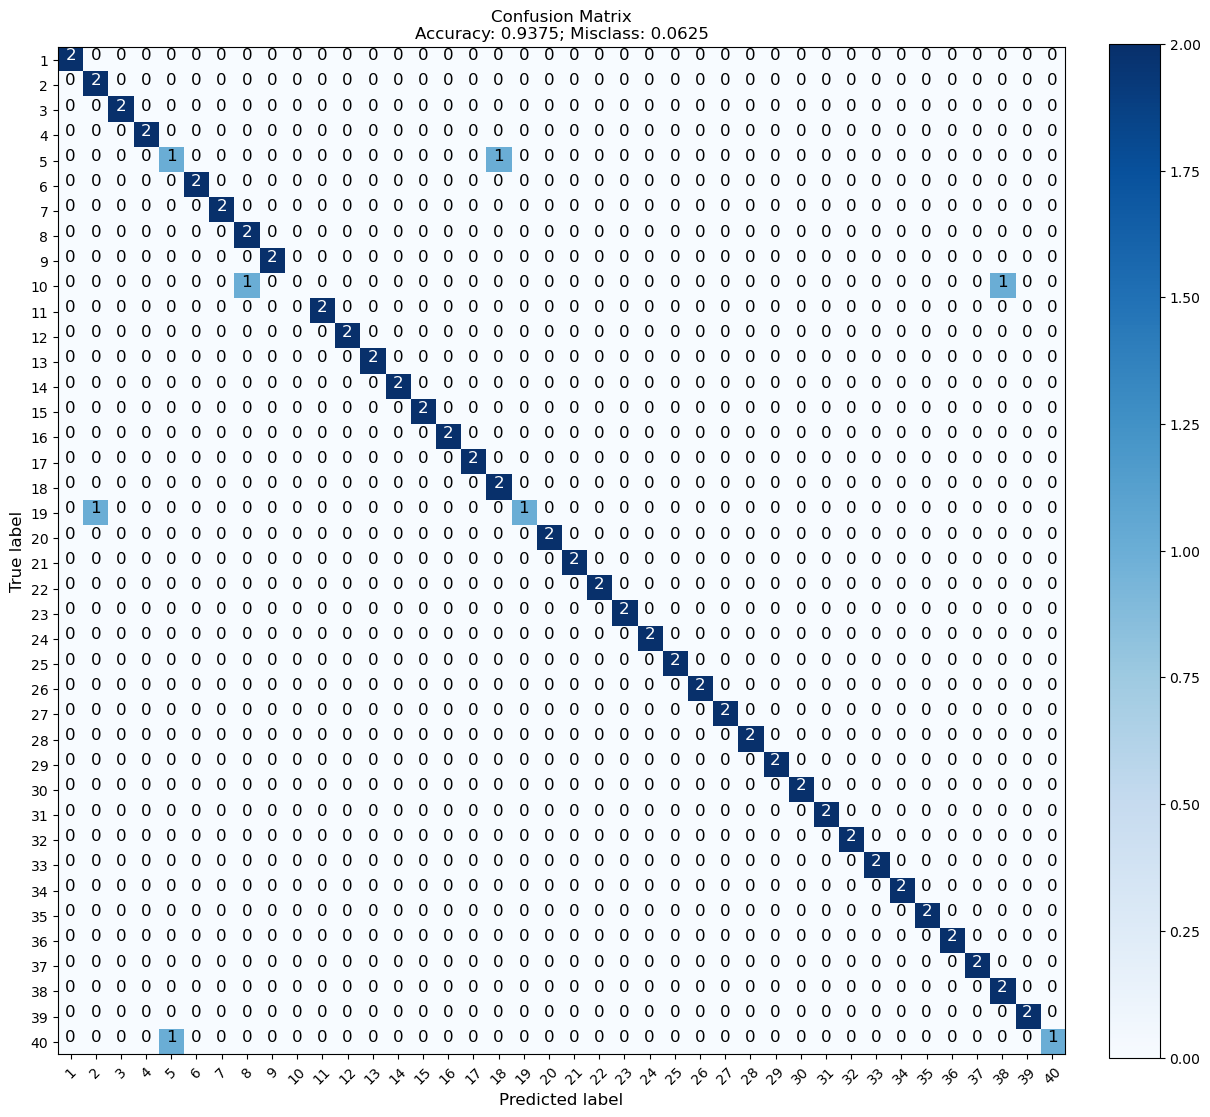

Overall Accuracy: 93%
Subject #1:
	TP: 2, FP: 0, TN: 78, FN: 0
	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%


In [1044]:
components_50=use_PCA_and_KNN(50,40, 8, 2)

For EACH of all the 40 subjects:
	8 images will be used for TRAINING: [1, 2, 3, 4, 5, 6, 7, 8]
	2 images will be used for TEST: [9, 10]



--------------------------
Applying PCA to the two sets: Training and Test...
Training the KNN...
--------------------------


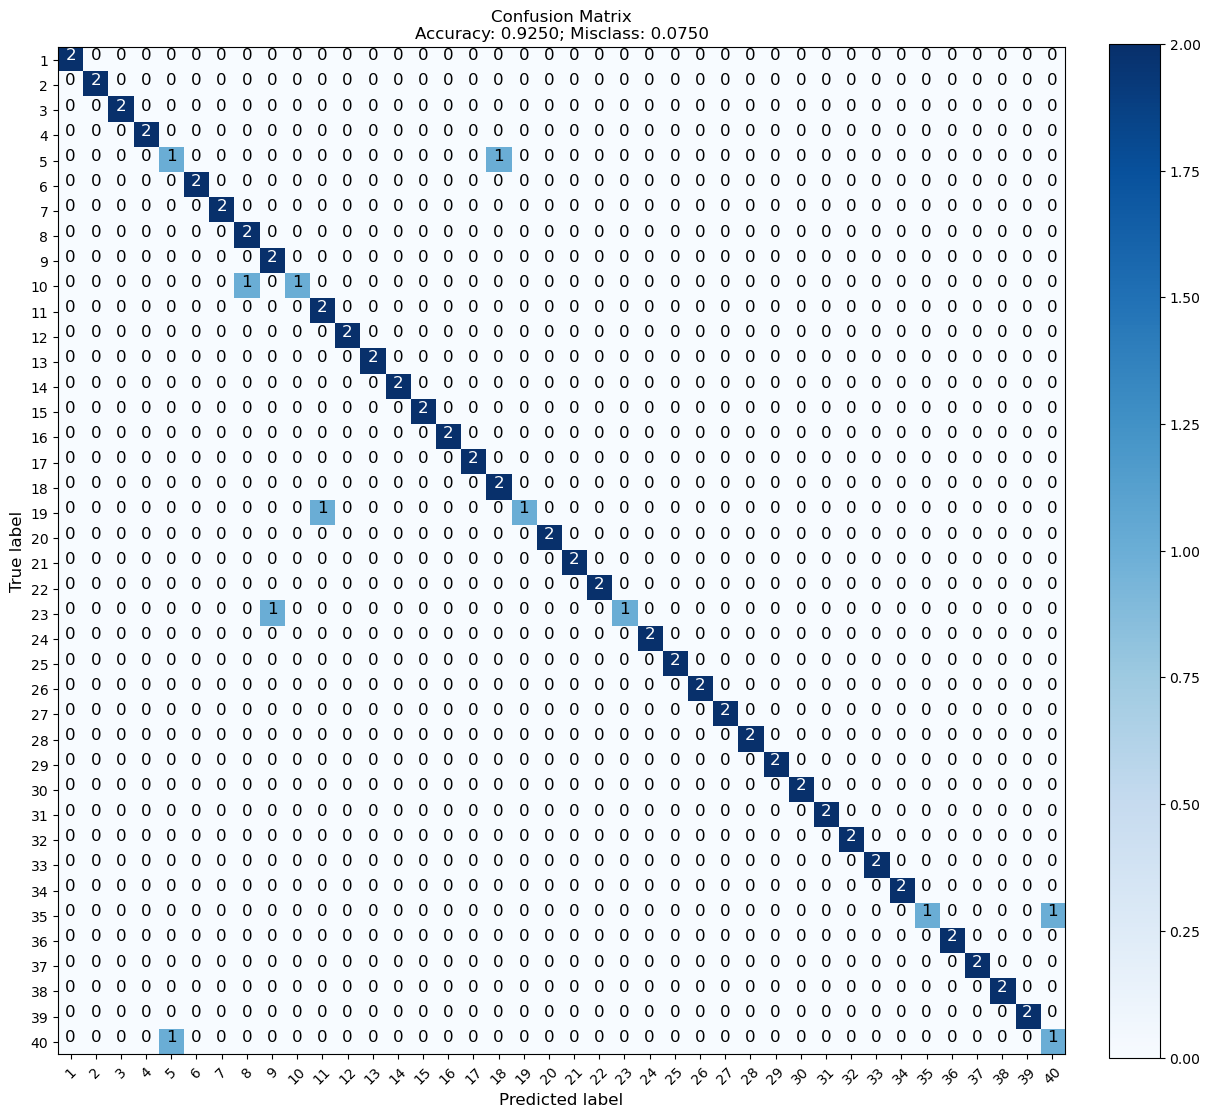

Overall Accuracy: 92%
Subject #1:
	TP: 2, FP: 0, TN: 78, FN: 0
	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%


In [1045]:
#this wasn't asked for but it is useful for better understanding the trends
components_25=use_PCA_and_KNN(25,40, 8, 2)

### comparing results

In [1046]:

def compare(content,title,limitLow=None,limitHigh=None):
	components=["50 components","100 components","200 components"]
	yAxix = [components_50[content], components_100[content], components_200[content]]
	print(yAxix)

	plt.title(title)
	if limitHigh!=None and limitLow!=None:
		plt.ylim(limitLow,limitHigh)
	plt.bar(components, yAxix) 









[92.5, 92.5, 93.75]


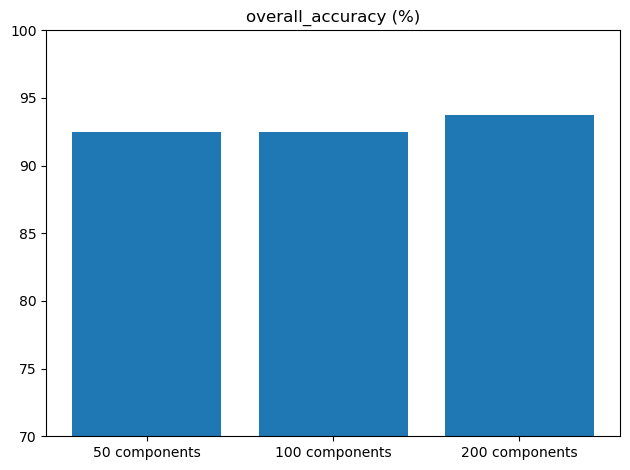

In [1047]:
compare('Overall Accuracy',"overall_accuracy (%)",70,100)

[2, 2, 2]


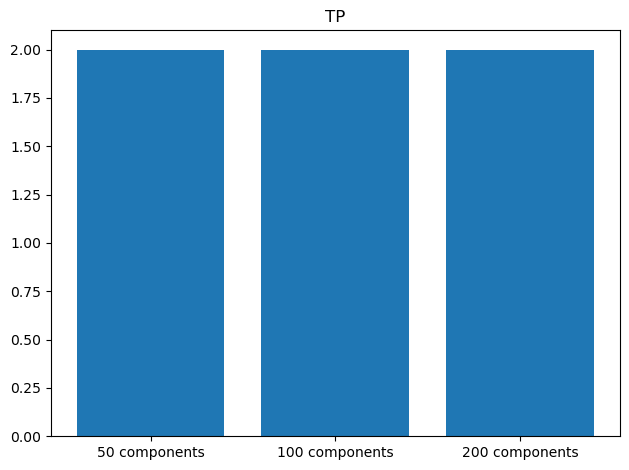

In [1048]:
compare('TP',"TP")

[0, 0, 0]


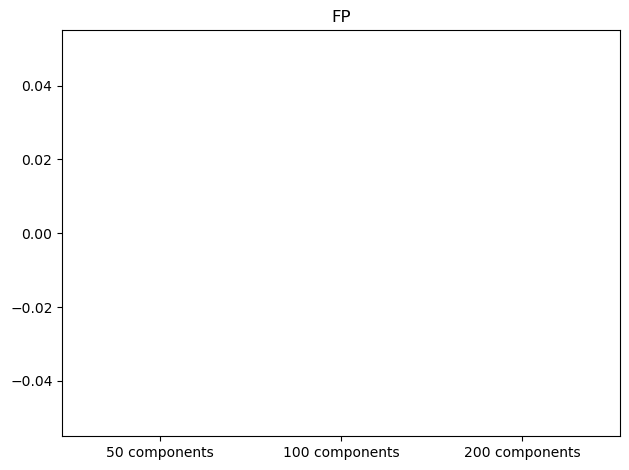

In [1049]:
compare('FP',"FP")

[78, 78, 78]


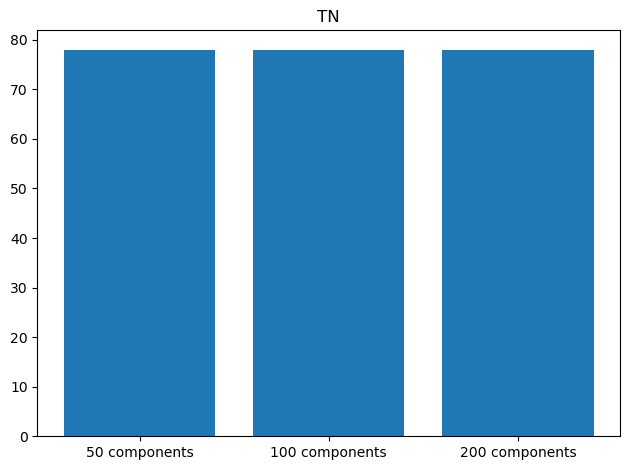

In [1050]:
compare('TN',"TN")

[0, 0, 0]


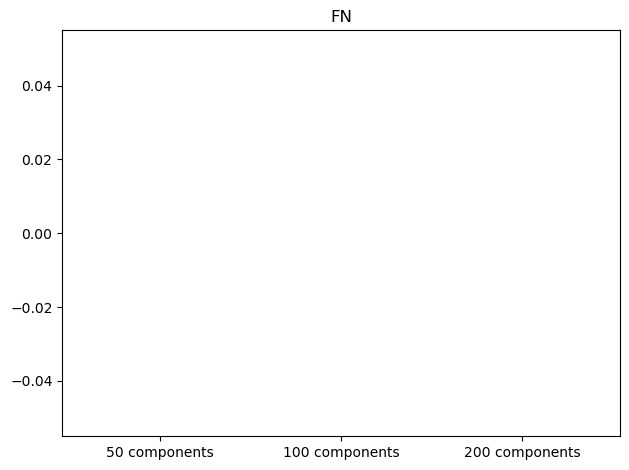

In [1051]:
compare('FN',"FN")

[100.0, 100.0, 100.0]


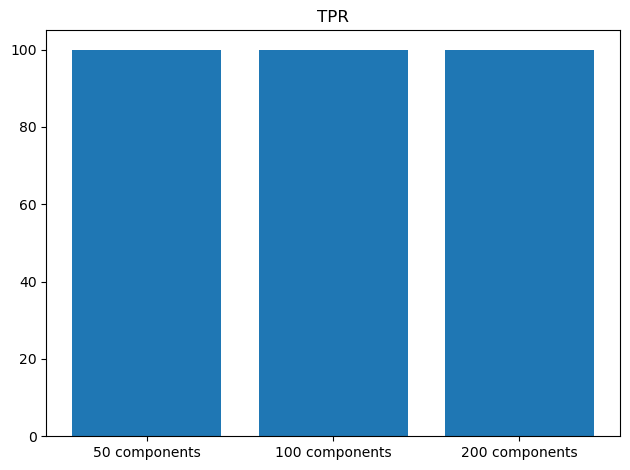

In [1052]:
compare('TPR',"TPR")

[0.0, 0.0, 0.0]


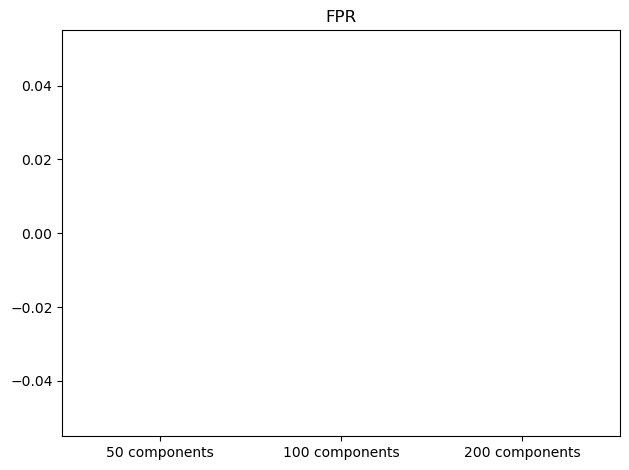

In [1053]:
compare('FPR',"FPR")

[100.0, 100.0, 100.0]


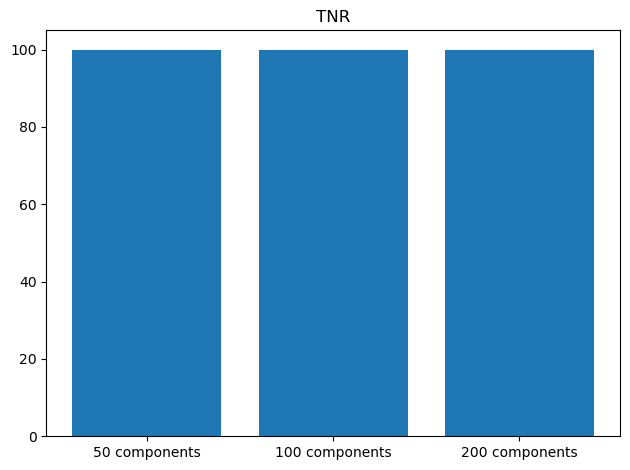

In [1054]:
compare('TNR',"TNR")

[0.0, 0.0, 0.0]


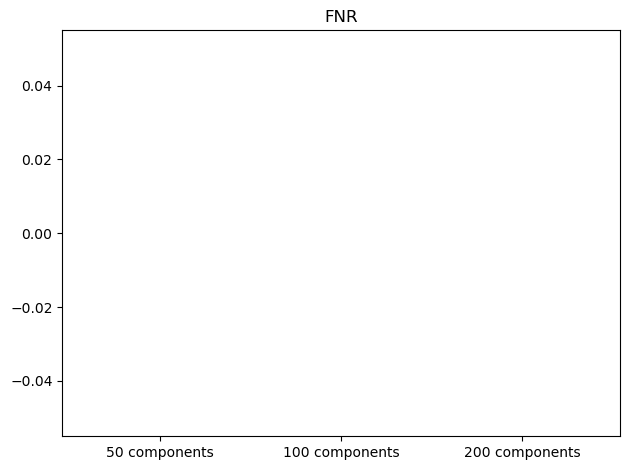

In [1055]:
compare('FNR',"FNR")

## Testing the results with a 5 to 5 test and train split

For EACH of all the 40 subjects:
	5 images will be used for TRAINING: [1, 2, 3, 4, 5]
	5 images will be used for TEST: [6, 7, 8, 9, 10]



--------------------------
Applying PCA to the two sets: Training and Test...
Training the KNN...
--------------------------


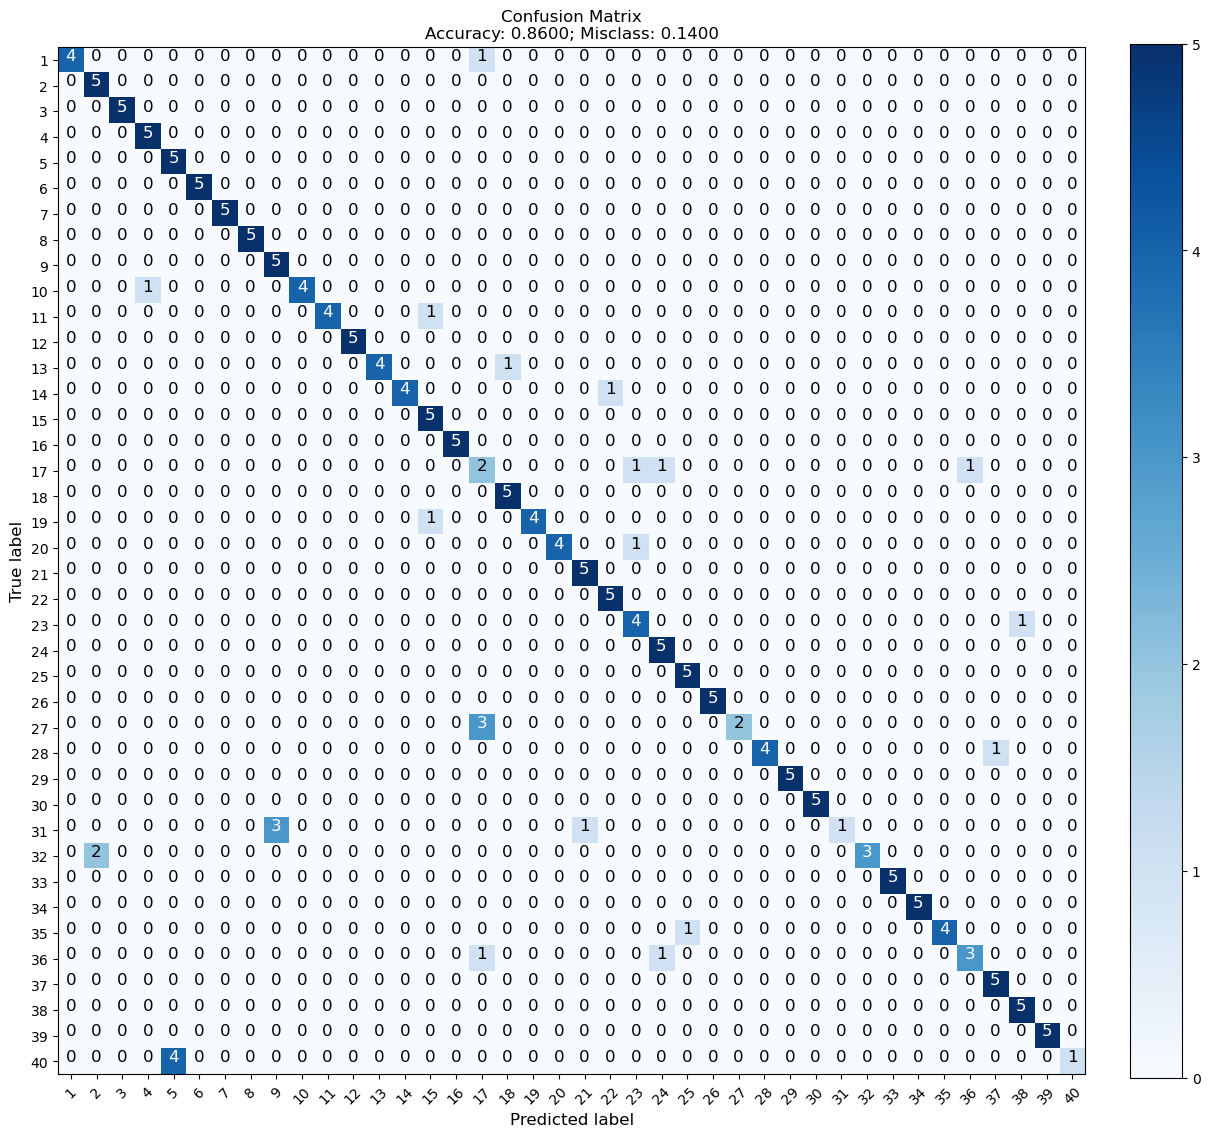

Overall Accuracy: 86%
Subject #1:
	TP: 4, FP: 0, TN: 195, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


In [1056]:
components_100=use_PCA_and_KNN(100, 40, 5, 5)

#### modified Data (Principal components = 200)

For EACH of all the 40 subjects:
	5 images will be used for TRAINING: [1, 2, 3, 4, 5]
	5 images will be used for TEST: [6, 7, 8, 9, 10]



--------------------------
Applying PCA to the two sets: Training and Test...
Training the KNN...
--------------------------


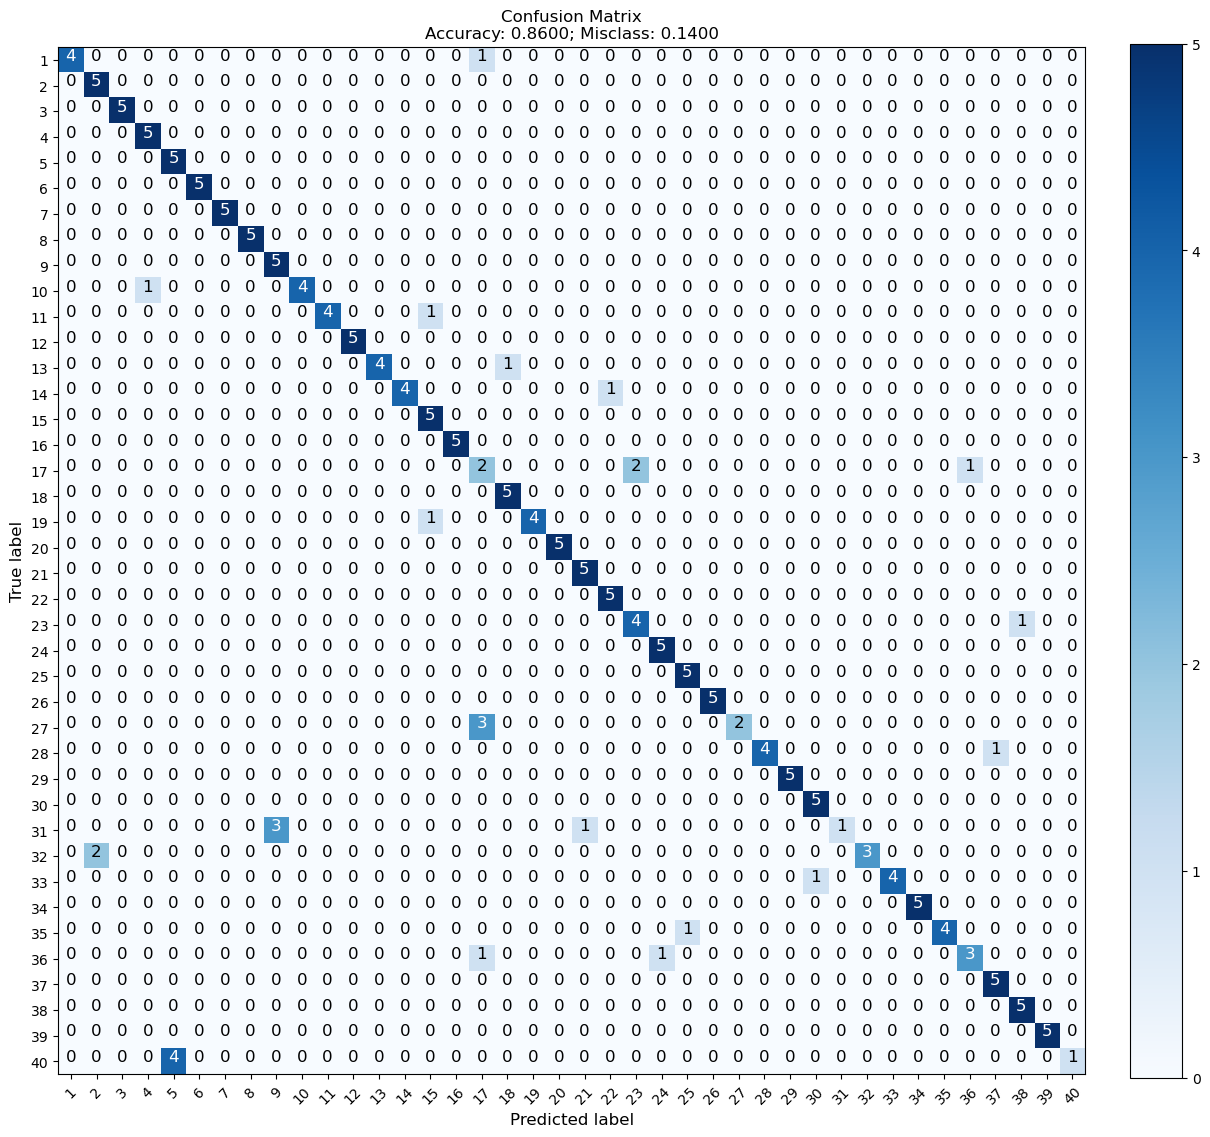

Overall Accuracy: 86%
Subject #1:
	TP: 4, FP: 0, TN: 195, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


In [1057]:
components_200=use_PCA_and_KNN(200,40, 5, 5)

#### modified Data (Principal components = 50)

For EACH of all the 40 subjects:
	5 images will be used for TRAINING: [1, 2, 3, 4, 5]
	5 images will be used for TEST: [6, 7, 8, 9, 10]



--------------------------
Applying PCA to the two sets: Training and Test...
Training the KNN...
--------------------------


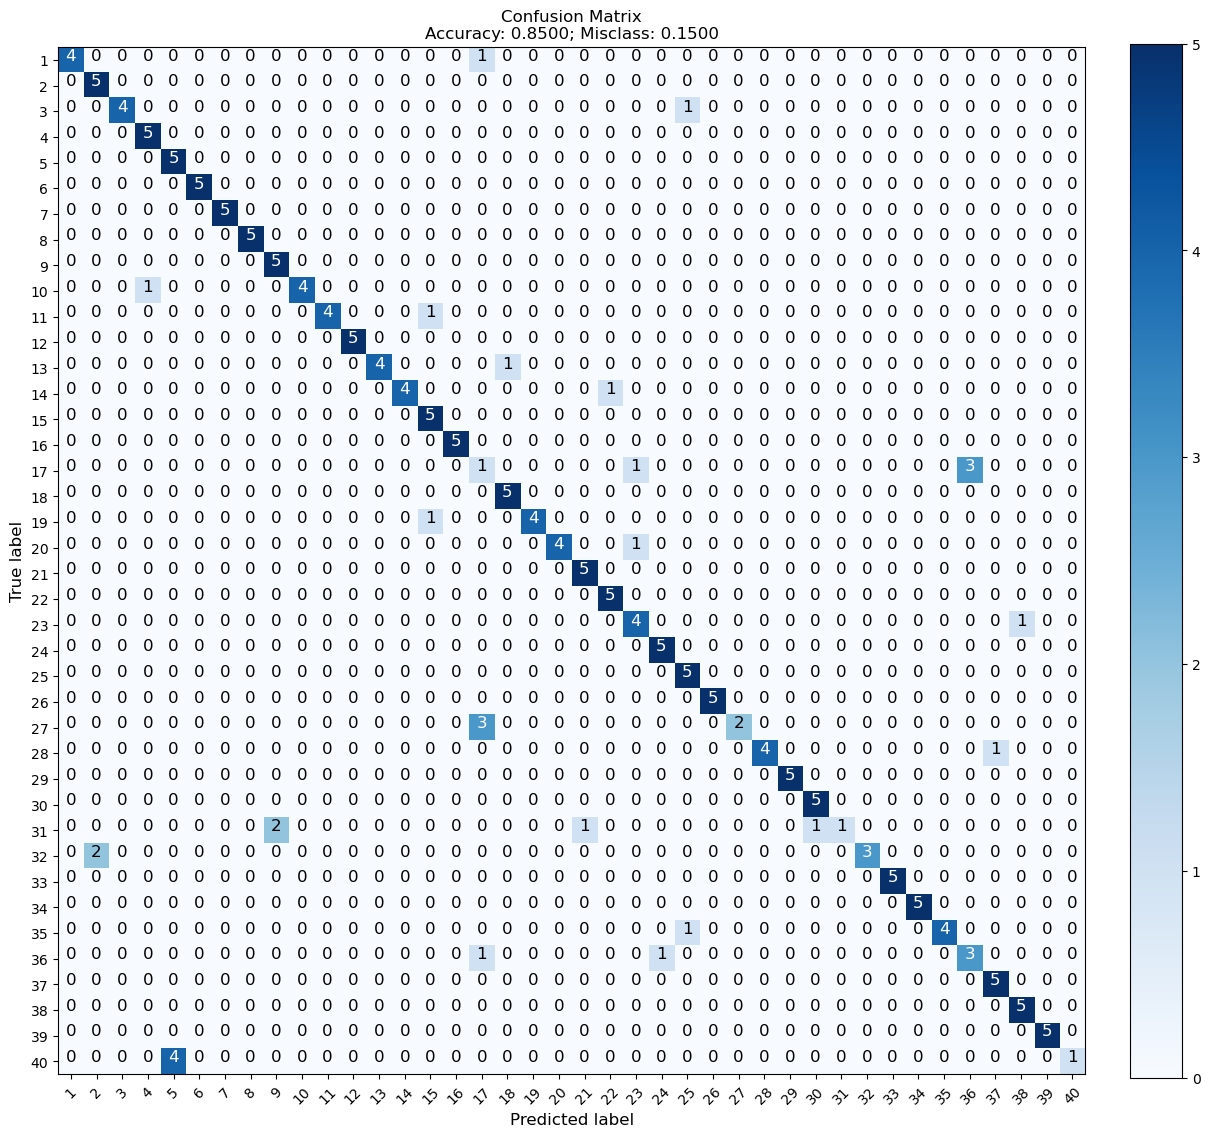

Overall Accuracy: 85%
Subject #1:
	TP: 4, FP: 0, TN: 195, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


In [1058]:
components_50=use_PCA_and_KNN(50,40, 5, 5)

For EACH of all the 40 subjects:
	5 images will be used for TRAINING: [1, 2, 3, 4, 5]
	5 images will be used for TEST: [6, 7, 8, 9, 10]



--------------------------
Applying PCA to the two sets: Training and Test...
Training the KNN...
--------------------------


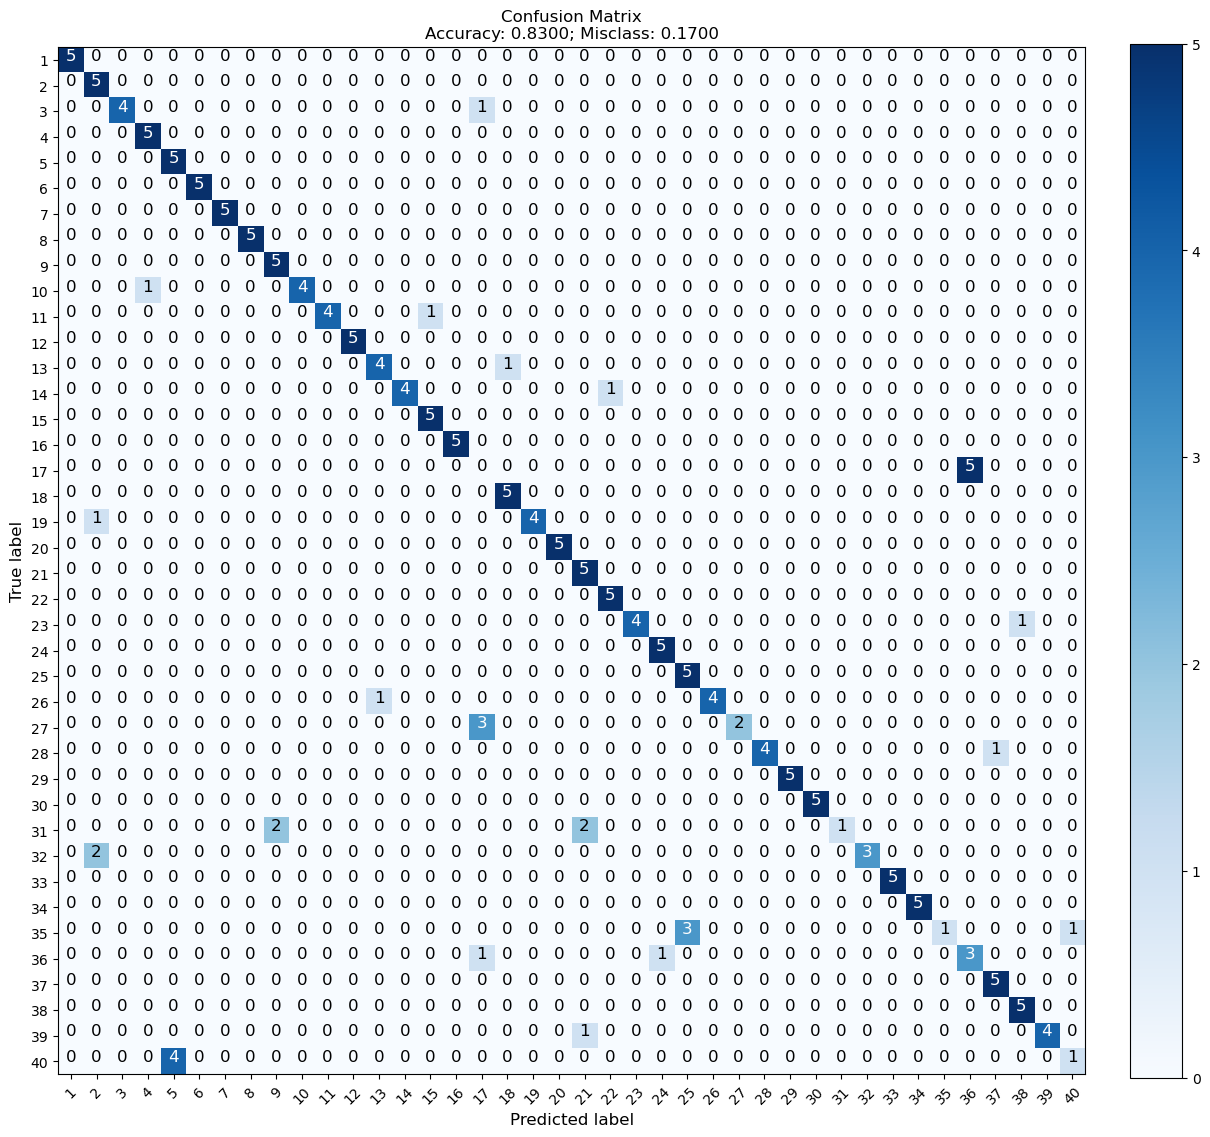

Overall Accuracy: 83%
Subject #1:
	TP: 5, FP: 0, TN: 195, FN: 0
	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%


In [1059]:
#this wasn't asked for but it is useful for better understanding the trends
components_25=use_PCA_and_KNN(25,40, 5, 5)

### comparing results

In [1060]:

def compare(content,title,limitLow=None,limitHigh=None):
	components=["50 components","100 components","200 components"]
	yAxix = [components_50[content], components_100[content], components_200[content]]
	print(yAxix)

	plt.title(title)
	if limitHigh!=None and limitLow!=None:
		plt.ylim(limitLow,limitHigh)
	plt.bar(components, yAxix) 









[85.0, 86.0, 86.0]


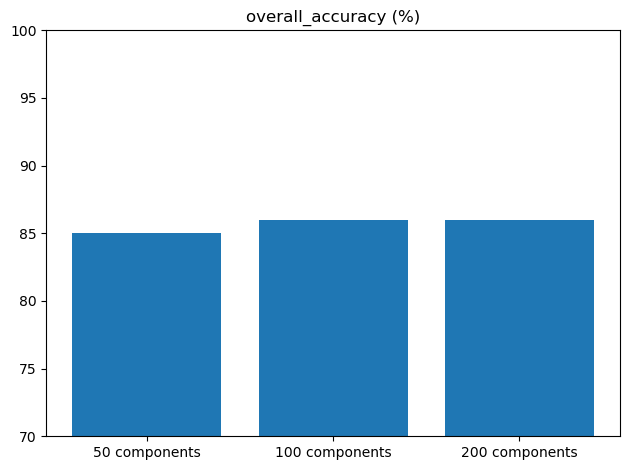

In [1061]:
compare('Overall Accuracy',"overall_accuracy (%)",70,100)

[4, 4, 4]


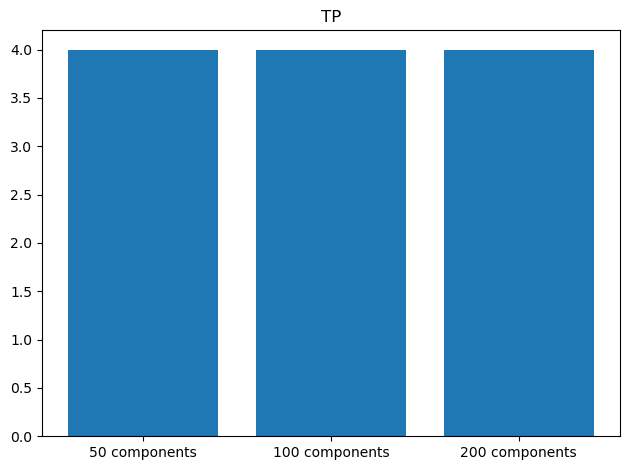

In [1062]:
compare('TP',"TP")

[0, 0, 0]


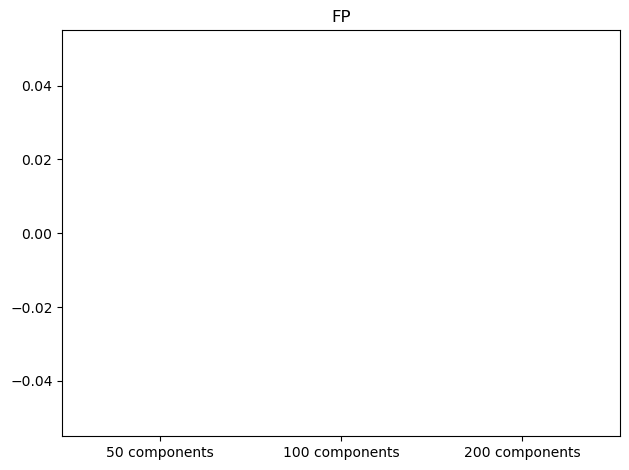

In [1063]:
compare('FP',"FP")

[195, 195, 195]


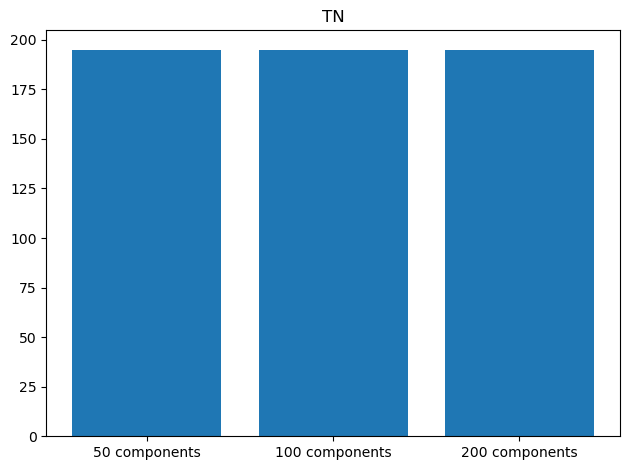

In [1064]:
compare('TN',"TN")

[1, 1, 1]


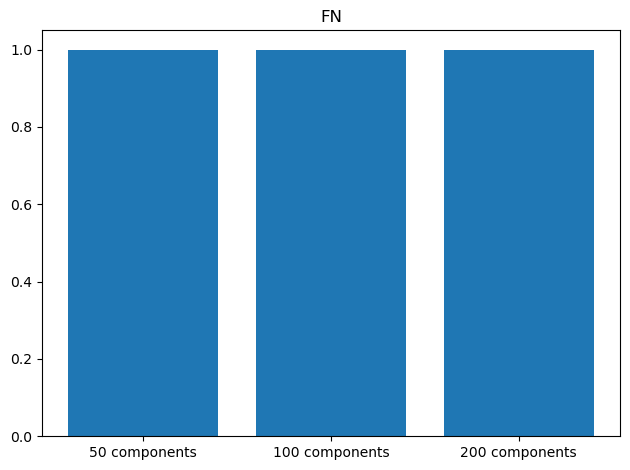

In [1065]:
compare('FN',"FN")

[80.0, 80.0, 80.0]


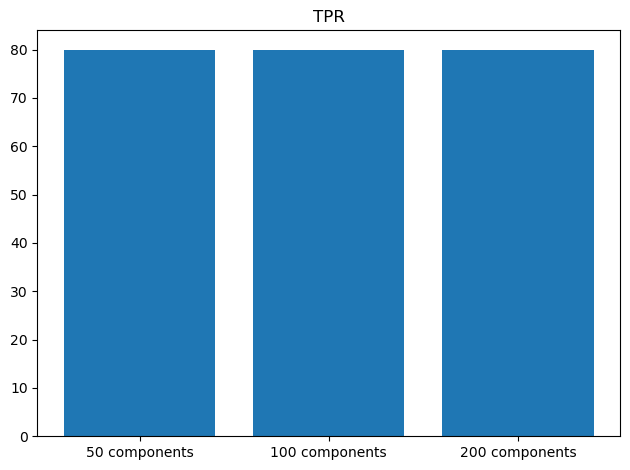

In [1066]:
compare('TPR',"TPR")

[0.0, 0.0, 0.0]


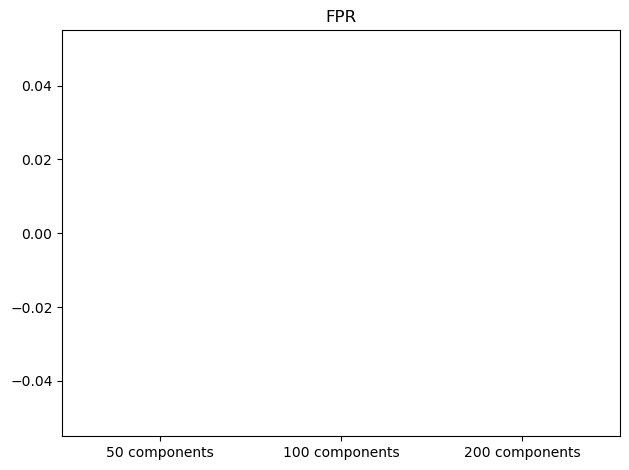

In [1067]:
compare('FPR',"FPR")

[100.0, 100.0, 100.0]


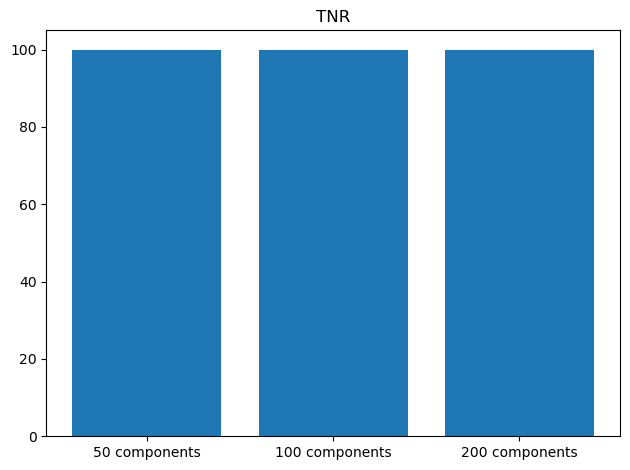

In [1068]:
compare('TNR',"TNR")

[20.0, 20.0, 20.0]


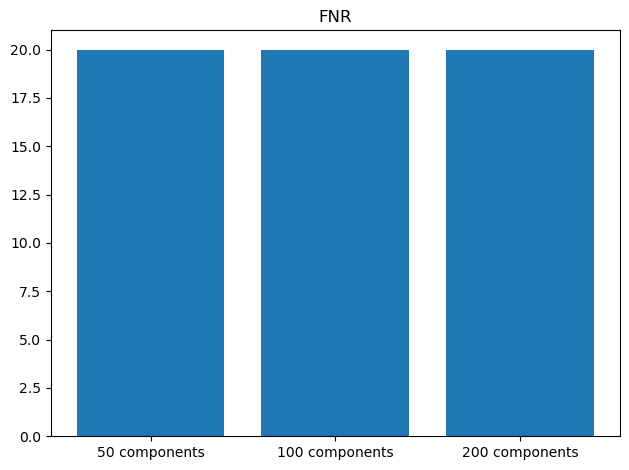

In [1069]:
compare('FNR',"FNR")

### Analysis
When looking the results, it becomes clear that the 8 to 2 training split results in overfitted data. This becomes clear with the high overall accuracy found in each case. In each case the overall accuracy was between 92 and 93. This trend was consistent with all the indicators including the True Positive, False Positive, True Negative, and False Negetive rates. The false rates were 0 and the true rates were 100, these trends are next to impossible and suggest that the data results are not reliable. This is further evident when looking at the confusion matrix for each case, the matrix was nearly identical in each case. 

However, when changing the training and test splits to 5 and 5 respectively, The results of changing the Princial Components still had little to no impact on the results. This suggests that the principal components after a certian number have little impact on the results of the algorithm. This makes sense as a large number of principal components result in more of the original training variance being preserved. This means that if their is a large number principal components, the algorithm will get to a point where it can't preserve more variance and no significant change will occur in the output. The confusion matrix also had a very minor impact but it still shows little change in the results.


- **Exercise 4** (2 marks): Evaluate the impact of the number of neighbors (K) defined for the KNN. Using the same data separation (20 subjects, 8 images per subject are used for training and 2 for testing). Conduct the two experiments considering, for example: 1) 5 neighbors and 2) 11 neighbors. Compare the KNN classifier results, using the Confusion matrices, and draw the conclusions.

### Reference Data (neighbors = 5)

For EACH of all the 20 subjects:
	8 images will be used for TRAINING: [1, 2, 3, 4, 5, 6, 7, 8]
	2 images will be used for TEST: [9, 10]



--------------------------
Applying PCA to the two sets: Training and Test...
Training the KNN...
--------------------------


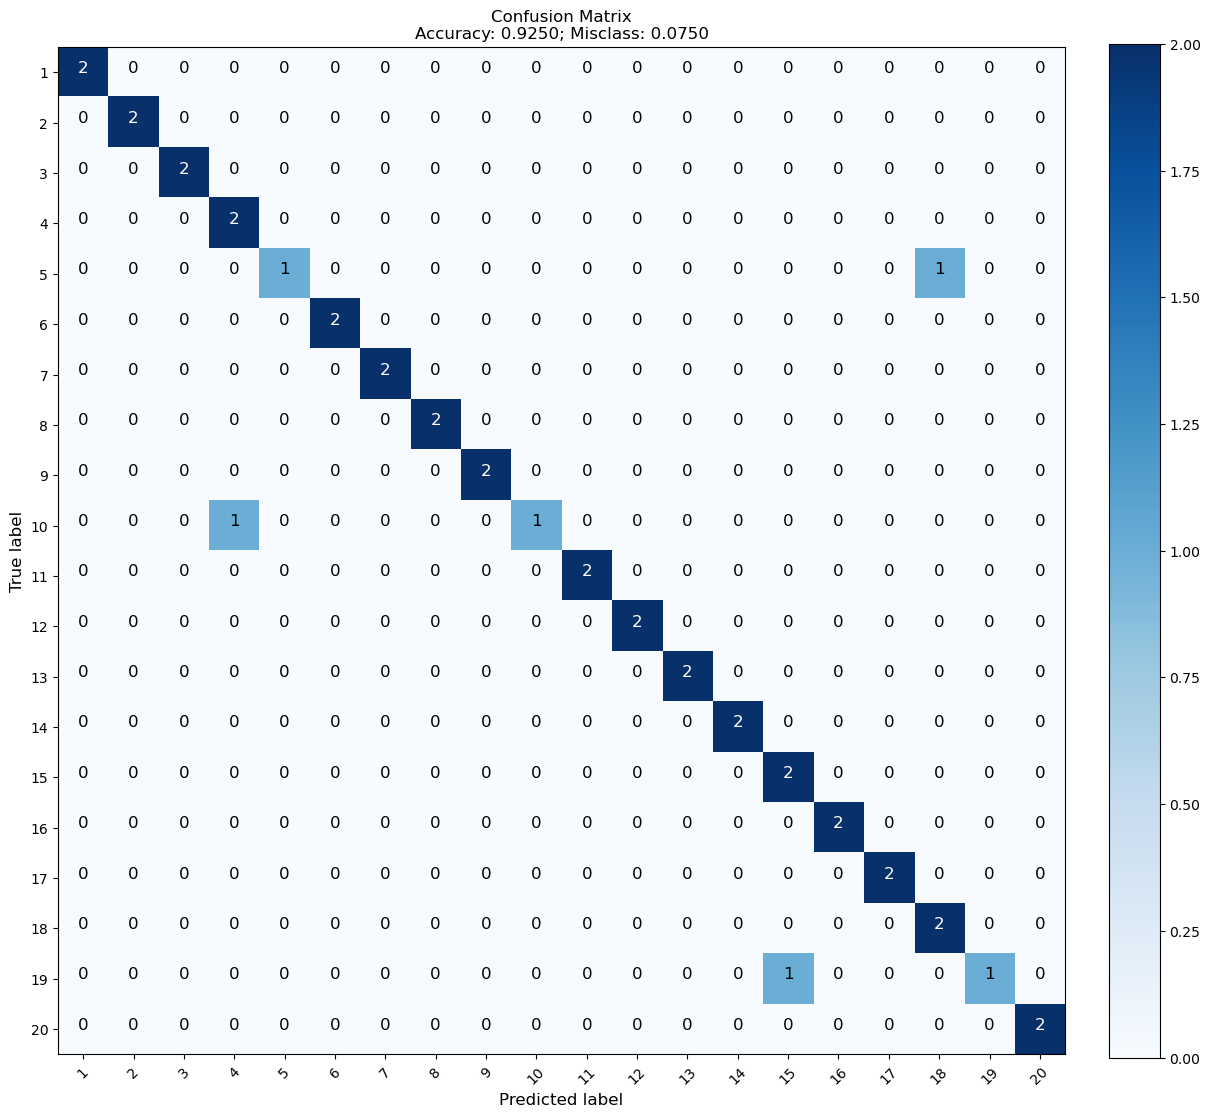

Overall Accuracy: 92%
Subject #1:
	TP: 2, FP: 0, TN: 38, FN: 0
	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%


In [1070]:
neighbors_3=use_PCA_and_KNN(train=8,test=2,neighbors=3)

### Modified Data (neighbors = 5)

For EACH of all the 20 subjects:
	8 images will be used for TRAINING: [1, 2, 3, 4, 5, 6, 7, 8]
	2 images will be used for TEST: [9, 10]



--------------------------
Applying PCA to the two sets: Training and Test...
Training the KNN...
--------------------------


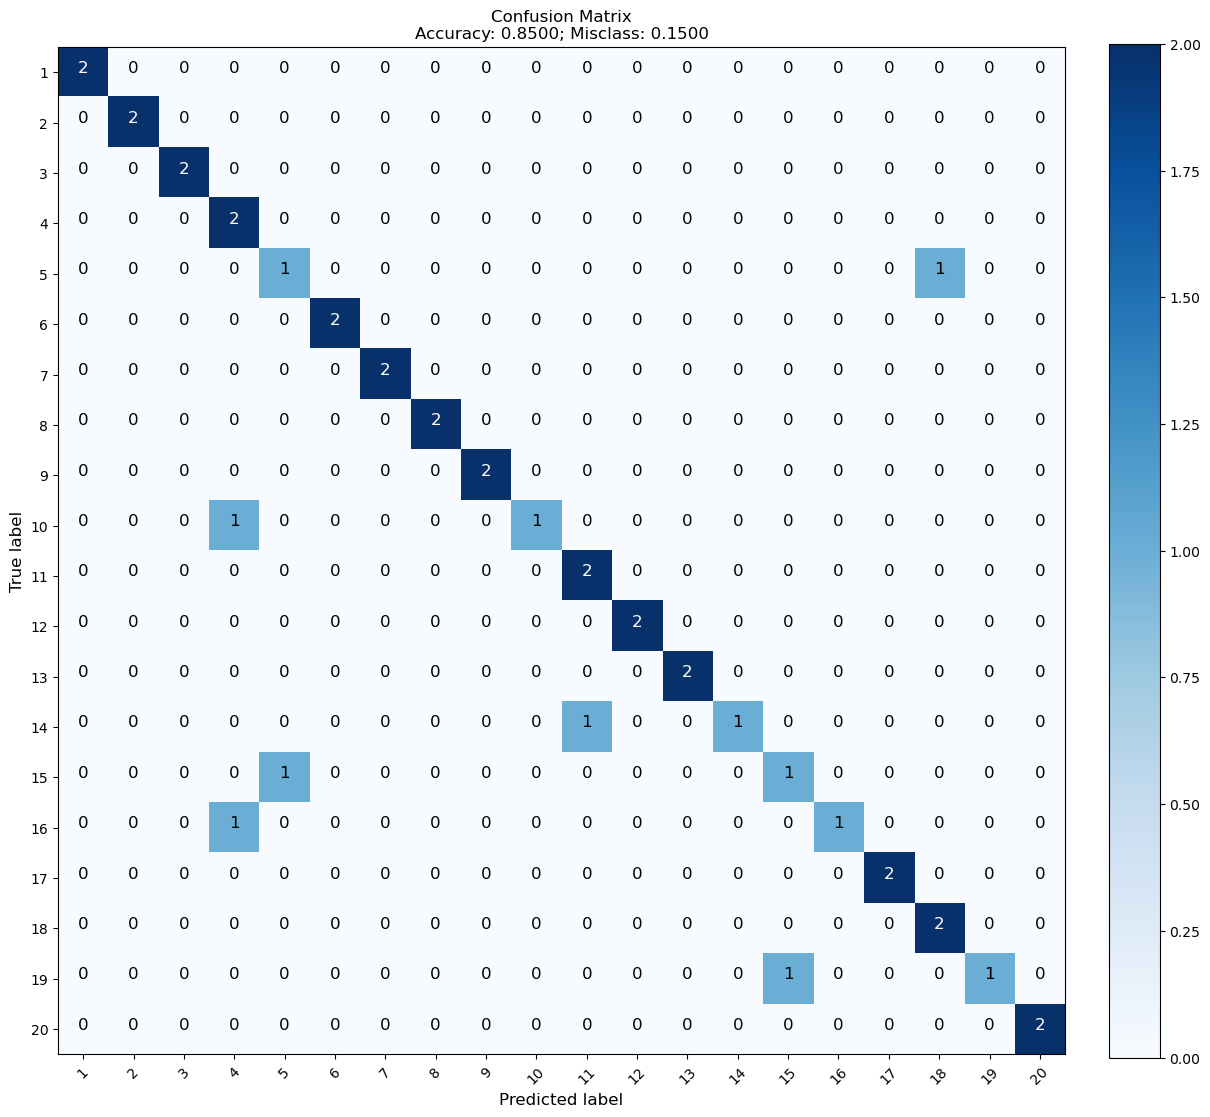

Overall Accuracy: 85%
Subject #1:
	TP: 2, FP: 0, TN: 38, FN: 0
	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%


In [1071]:
neighbors_5=use_PCA_and_KNN(train=8,test=2,neighbors=6)

### Modified Data (neighbors = 11)

For EACH of all the 20 subjects:
	8 images will be used for TRAINING: [1, 2, 3, 4, 5, 6, 7, 8]
	2 images will be used for TEST: [9, 10]



--------------------------
Applying PCA to the two sets: Training and Test...


Training the KNN...
--------------------------


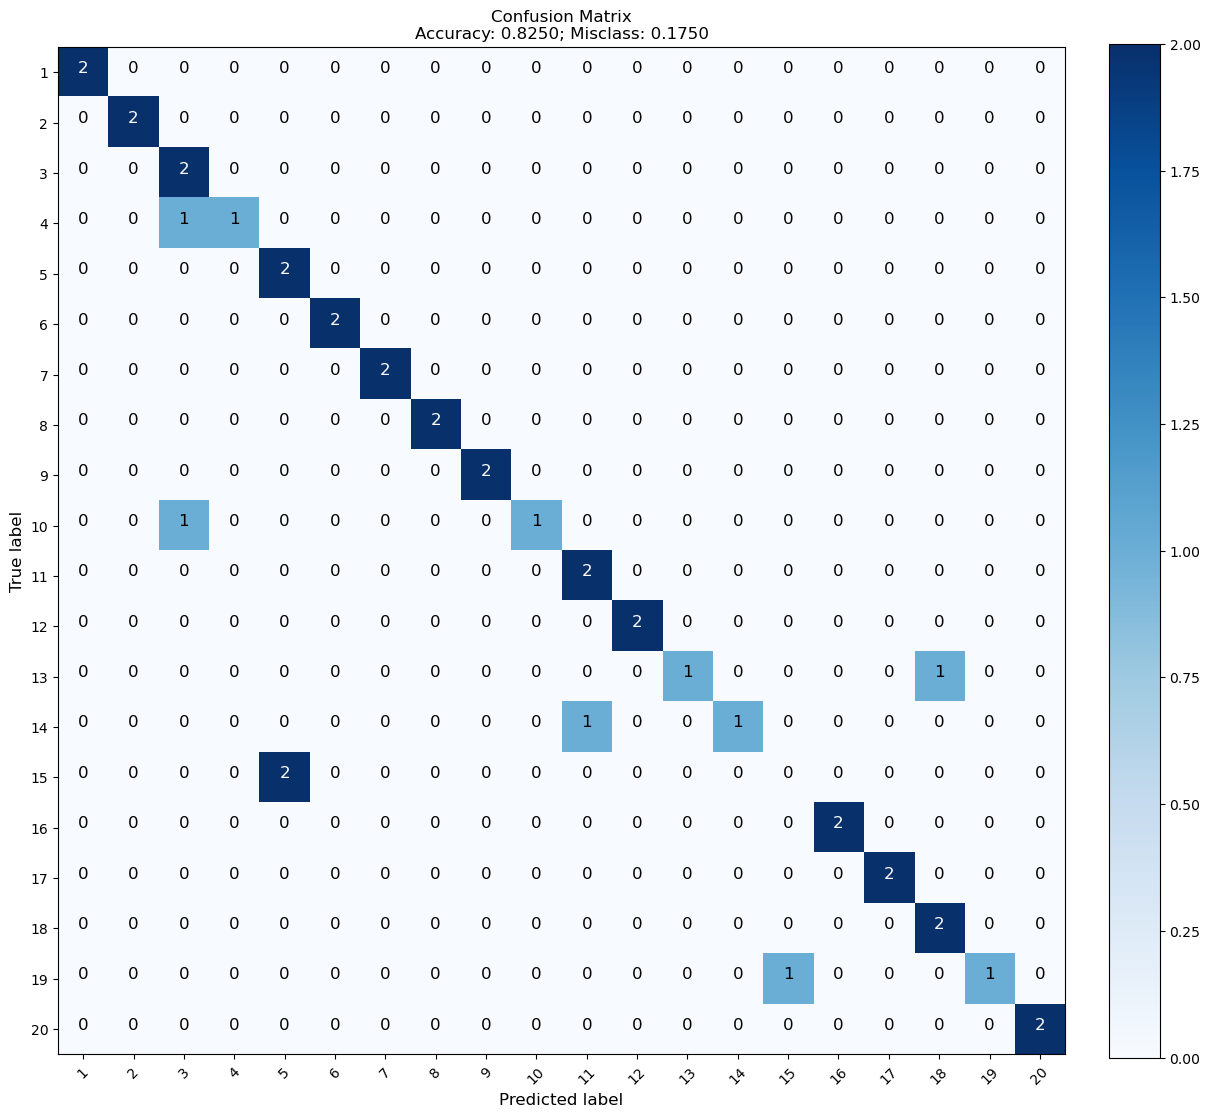

Overall Accuracy: 82%
Subject #1:
	TP: 2, FP: 0, TN: 38, FN: 0
	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%


In [1072]:
neighbors_11=use_PCA_and_KNN(train=8,test=2,neighbors=11)

### Analysis

As the number of K neighbors increased, the results of the alogrithm became less accurate but the number of false negatives and false postives did not have a significant change. When analyzing the confusion matrix of each scenario. It becomes clear that an increase in K neighbors is inversely proportional to the success of the classification. As the k neighbors increase, the decision boundry becomes weaker and you see more outliers. This suggests that after a certian point, The model was becoming uderfitted as the k neighbors increased. The k neighbors value directly relates to the bias that is present in the model, as the k neighbors increase, the algorithm becomes more bias and therfore has a harder time matching things in practical a classification scenario.